In [1]:
%cd ~/REVIVAL2

/disk2/fli/REVIVAL2


In [2]:
%load_ext blackcellmagic

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# vis based on different metrics 
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

import warnings

from REVIVAL.analysis import ndcg, ndcg_scale, custom_ndcg, calc_top_n_percent_recall
from REVIVAL.util import get_file_name

# Suppress only ConstantInputWarning
warnings.simplefilter("ignore", category=UserWarning)


/disk2/fli/miniconda3/envs/REVIVAL/lib/python3.11/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [13]:
parlqb = pd.read_csv("/disk2/fli/REVIVAL2/zs/comb/ParLQ-b.csv")
parlqb

AAs                       var    fitness  selectivity  n_mut enzyme  \
0   GPFAW  W56G:Y57P:L59F:Q60A:F89W   2.996901     0.180043      5  ParLQ   
1   HYMAY       W56H:L59M:Q60A:F89Y  16.934836     6.359406      4  ParLQ   
2   MEMDW  W56M:Y57E:L59M:Q60D:F89W  17.609432     0.932284      5  ParLQ   
3   WYLQF                        WT  18.329205     0.814598      0  ParLQ   
4   WYLQF                        WT  18.564456     0.785790      0  ParLQ   
..    ...                       ...        ...          ...    ...    ...   
91  FYFDY       W56F:L59F:Q60D:F89Y  82.274400    15.252473      4  ParLQ   
92  HKFDY  W56H:Y57K:L59F:Q60D:F89Y  82.541131    10.950994      5  ParLQ   
93  MKFKY  W56M:Y57K:L59F:Q60K:F89Y  82.691752    11.646061      5  ParLQ   
94  MKFDY  W56M:Y57K:L59F:Q60D:F89Y  89.271628    10.153336      5  ParLQ   
95  PKMDY  W56P:Y57K:L59M:Q60D:F89Y  91.813213    15.718841      5  ParLQ   

     hd                                                seq AA1 AA2  ...  \
0  -5.0  MAVPGYDFGKVPDAPISDADFESLKKTVMWGEEDEKYRKMACEALK...   G   P  ...   
1  -4.0  MAVPGYDFGKVPDAPISDADFESLKKTVMWGEEDEKYRKMACEALK...   H   Y  ...   
2  -5.0  MAVPGYDFGKVPDAPISDADFESLKKTVMWGEEDEKYRKMACEALK...   M   E  ...   
3   NaN  MAVPGYDFGKVPDAPISDADFESLKKTVMWGEEDEKYRKMACEALK...   W   Y  ...   
4   NaN  MAVPGYDFGKVPDAPISDADFESLKKTVMWGEEDEKYRKMACEALK...   W   Y  ...   
..  ...                                                ...  ..  ..  ...   
91 -4.0  MAVPGYDFGKVPDAPISDADFESLKKTVMWGEEDEKYRKMACEALK...   F   Y  ...   
92 -5.0  MAVPGYDFGKVPDAPISDADFESLKKTVMWGEEDEKYRKMACEALK...   H   K  ...   
93 -5.0  MAVPGYDFGKVPDAPISDADFESLKKTVMWGEEDEKYRKMACEALK...   M   K  ...   
94 -5.0  MAVPGYDFGKVPDAPISDADFESLKKTVMWGEEDEKYRKMACEALK...   M   K  ...   
95 -5.0  MAVPGYDFGKVPDAPISDADFESLKKTVMWGEEDEKYRKMACEALK...   P   K  ...   

   num_interactions_agg_af3-score_seperate  \
0                                     39.0   
1                                     38.0   
2                                     36.0   
3                                      NaN   
4                                      NaN   
..                                     ...   
91                                    41.0   
92                                    36.0   
93                                    39.0   
94                                    38.0   
95                                    37.0   

   vina_af3-score_seperate-substrate_cofactor-score_only  \
0                                                 NaN      
1                                                 NaN      
2                                                 NaN      
3                                                 NaN      
4                                                 NaN      
..                                                ...      
91                                                NaN      
92                                                NaN      
93                                                NaN      
94                                                NaN      
95                                                NaN      

   vina_min_af3-score_seperate-substrate_cofactor-score_only  \
0                                                 NaN          
1                                                 NaN          
2                                                 NaN          
3                                                 NaN          
4                                                 NaN          
..                                                ...          
91                                                NaN          
92                                                NaN          
93                                                NaN          
94                                                NaN          
95                                                NaN          

    vina_max_af3-score_seperate-substrate_cofactor-score_only  \
0                                                 NaN           
1      

In [5]:
fit_rho_list = []
fit_ndcg_list = []
fit_top10_list = []
fit_top25_list = []
fit_top50_list = []

sele_rho_list = []
sele_ndcg_list = []
sele_top10_list = []
sele_top25_list = []
sele_top50_list = []

for f in glob("/disk2/fli/REVIVAL2/zs/comb/*.csv"):
    df_original = pd.read_csv(f)
    # see if the fitness is a string
    if df_original["fitness"].dtype == "O":
        # convert fitness to numerical
        df_original["fitness"] = pd.to_numeric(df_original["fitness"].str.replace(",", ""), errors='coerce')
    df_original = df_original[df_original.select_dtypes(include=["number"]).columns]
    df_name = get_file_name(f)
    print(df_name)

    rho_dict = {"lib": df_name}
    ndcg_dict = {"lib": df_name}
    top10_dict = {"lib": df_name}
    top25_dict = {"lib": df_name}
    top50_dict = {"lib": df_name}

    if "selectivity" in df_original.columns:
        add_selectivity = True
        sele_rho_dict = {"lib": df_name}
        sele_ndcg_dict = {"lib": df_name}
        sele_top10_dict = {"lib": df_name}
        sele_top25_dict = {"lib": df_name}
        sele_top50_dict = {"lib": df_name}
    else:
        add_selectivity = False

    for c in df_original.columns:
        if c == "fitness" or "_rank" in c:
            continue
        # check if nan is in the column, if so print out the rows with nan
        # if df_original[c].isna().sum() > 0:
            # print(c)
            # print(len(df_original[df_original[c].isna()]))
        # now slice out the rows without nan
        df = df_original[df_original[c].notna()]
        if len(df) == 0:
            rho_dict[c] = np.nan
            ndcg_dict[c] = np.nan
            top10_dict[c] = np.nan
            top25_dict[c] = np.nan
            top50_dict[c] = np.nan

            if add_selectivity:
                sele_rho_dict[c] = np.nan
                sele_ndcg_dict[c] = np.nan
                sele_top10_dict[c] = np.nan
                sele_top25_dict[c] = np.nan
                sele_top50_dict[c] = np.nan

        else:

            y_true = df["fitness"].values
            y_score = df[c].values

            if (
                "Triad_score" in c
                or "chain_pae_min" in c
                or "sum_" in c
                or "naive_score" in c
                or c == "complexscore"
                or c == "dH"
                or c == "ligscore"
                or c == "recscore"
                or c == "score"
                or c == "total_score"
                or "vina_" in c
                or "0:" in c
                or "1:" in c
                or "2:" in c
                or "_vol" in c
            ):
                y_score = -1 * y_score
                # print(f"flipping {c}")
            if " - " in c:
                y_score = np.abs(y_score)
            if np.all(y_score == y_score[0]):  # Check if all values are identical
                rho_dict[c] = np.nan  # Assign NaN or 0 if needed
            else:
                rho_dict[c] = spearmanr(y_true, y_score).correlation
            ndcg_dict[c] = ndcg_scale(y_true=y_true, y_pred=y_score)
            top10_dict[c] = calc_top_n_percent_recall(
                y_true=y_true, y_score=y_score, top_n=10
            )
            top25_dict[c] = calc_top_n_percent_recall(
                y_true=y_true, y_score=y_score, top_n=25
            )
            top50_dict[c] = calc_top_n_percent_recall(
                y_true=y_true, y_score=y_score, top_n=50
            )

            if add_selectivity and c != "selectivity":
                y_true_sele = df["selectivity"].values
                y_score_sele = y_score

                if np.all(
                    y_score_sele == y_score_sele[0]
                ):  # Check if all values are identical
                    sele_rho_dict[c] = np.nan
                else:
                    sele_rho_dict[c] = spearmanr(y_true_sele, y_score_sele).correlation
                sele_ndcg_dict[c] = ndcg_scale(y_true=y_true_sele, y_pred=y_score_sele)
                sele_top10_dict[c] = calc_top_n_percent_recall(
                    y_true=y_true_sele, y_score=y_score_sele, top_n=10
                )
                sele_top25_dict[c] = calc_top_n_percent_recall(
                    y_true=y_true_sele, y_score=y_score_sele, top_n=25
                )
                sele_top50_dict[c] = calc_top_n_percent_recall(
                    y_true=y_true_sele, y_score=y_score_sele, top_n=50
                )

    fit_rho_list.append(rho_dict)
    fit_ndcg_list.append(ndcg_dict)
    fit_top10_list.append(top10_dict)
    fit_top25_list.append(top25_dict)
    fit_top50_list.append(top50_dict)

    if add_selectivity:
        sele_rho_list.append(sele_rho_dict)
        sele_ndcg_list.append(sele_ndcg_dict)
        sele_top10_list.append(sele_top10_dict)
        sele_top25_list.append(sele_top25_dict)
        sele_top50_list.append(sele_top50_dict)

df_rho_fit = pd.DataFrame(fit_rho_list)
df_ndcg_fit = pd.DataFrame(fit_ndcg_list)
df_top10_fit = pd.DataFrame(fit_top10_list)
df_top25_fit = pd.DataFrame(fit_top25_list)
df_top50_fit = pd.DataFrame(fit_top50_list)
df_rho_sele = pd.DataFrame(sele_rho_list)
df_ndcg_sele = pd.DataFrame(sele_ndcg_list)
df_top10_sele = pd.DataFrame(sele_top10_list)
df_top25_sele = pd.DataFrame(sele_top25_list)
df_top50_sele = pd.DataFrame(sele_top50_list)

# save them all 
df_rho_fit.to_csv("/disk2/fli/REVIVAL2/zs/metrics/fit_rho.csv", index=False)
df_ndcg_fit.to_csv("/disk2/fli/REVIVAL2/zs/metrics/fit_ndcg.csv", index=False)
df_top10_fit.to_csv("/disk2/fli/REVIVAL2/zs/metrics/fit_top10.csv", index=False)
df_top25_fit.to_csv("/disk2/fli/REVIVAL2/zs/metrics/fit_top25.csv", index=False)
df_top50_fit.to_csv("/disk2/fli/REVIVAL2/zs/metrics/fit_top50.csv", index=False)
df_rho_sele.to_csv("/disk2/fli/REVIVAL2/zs/metrics/sele_rho.csv", index=False)
df_ndcg_sele.to_csv("/disk2/fli/REVIVAL2/zs/metrics/sele_ndcg.csv", index=False)
df_top10_sele.to_csv("/disk2/fli/REVIVAL2/zs/metrics/sele_top10.csv", index=False)
df_top25_sele.to_csv("/disk2/fli/REVIVAL2/zs/metrics/sele_top25.csv", index=False)
df_top50_sele.to_csv("/disk2/fli/REVIVAL2/zs/metrics/sele_top50.csv", index=False)

ParLQ
PfTrpB-5iodo
PfTrpB-5bromo
PfTrpB-5cyano
ParLQ-c
ParLQ-g
PfTrpB-56chloro
ParLQ-i
ParLQ-d
PfTrpB-6chloro
ParLQ-f
Rma-CSi_scope
Rma-CB
ParLQ-b
Rma-CSi
Rma-CB_scope
PfTrpB-4cyano
PfTrpB-4bromo
PfTrpB_scope
ParLQ-e
PfTrpB-7iodo
PfTrpB-7methyl
PfTrpB-7bromo
ParLQ-h
PfTrpB-5chloro


In [6]:
custom_order = [
    "PfTrpB-7iodo",
    "PfTrpB-7methyl",
    "PfTrpB-7bromo",
    "PfTrpB-5iodo",
    "PfTrpB-5bromo",
    "PfTrpB-5chloro",
    "PfTrpB-4bromo",
    "PfTrpB-6chloro",
    "PfTrpB-5cyano",
    "PfTrpB-4cyano",
    "PfTrpB-56chloro",
    "Rma-CB",
    "Rma-CSi",
    "ParLQ",
    "ParLQ-b",
    "ParLQ-c",
    "ParLQ-d",
    "ParLQ-e",
    "ParLQ-f",
    "ParLQ-g",
    "ParLQ-h",
    "ParLQ-i",
]
# substrate
# 7iodo       0.605263
# 7methyl     0.605263
# 7bromo      0.605263
# 5iodo       0.600000
# 5bromo      0.600000
# 5chloro     0.600000
# 4bromo      0.550000
# 6chloro     0.536585
# 5cyano      0.489796
# 4cyano      0.489362
# 56chloro    0.333333
# Name: Atom Pair, dtype: float64

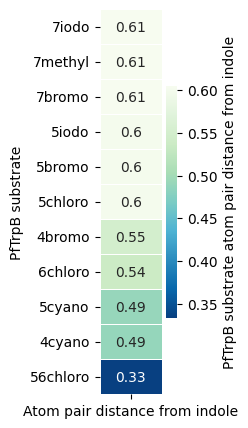

In [9]:

# Sample data
data = {
    "PfTrpB substrate": [
        "7iodo", "7methyl", "7bromo", "5iodo", "5bromo",
        "5chloro", "4bromo", "6chloro", "5cyano", "4cyano", "56chloro"
    ],
    "Atom pair distance from indole": [
        0.605263, 0.605263, 0.605263, 0.600000, 0.600000,
        0.600000, 0.550000, 0.536585, 0.489796, 0.489362, 0.333333
    ]
}

# Convert to DataFrame
df = pd.DataFrame(data).set_index("PfTrpB substrate")

# Set figure size
plt.figure(figsize=(1, 5))

# Create heatmap with grayscale colormap
sns.heatmap(df, cmap="GnBu_r", annot=True, linewidths=0.5, cbar_kws={"label": "PfTrpB substrate atom pair distance from indole"}  )

# Show plot
plt.show()


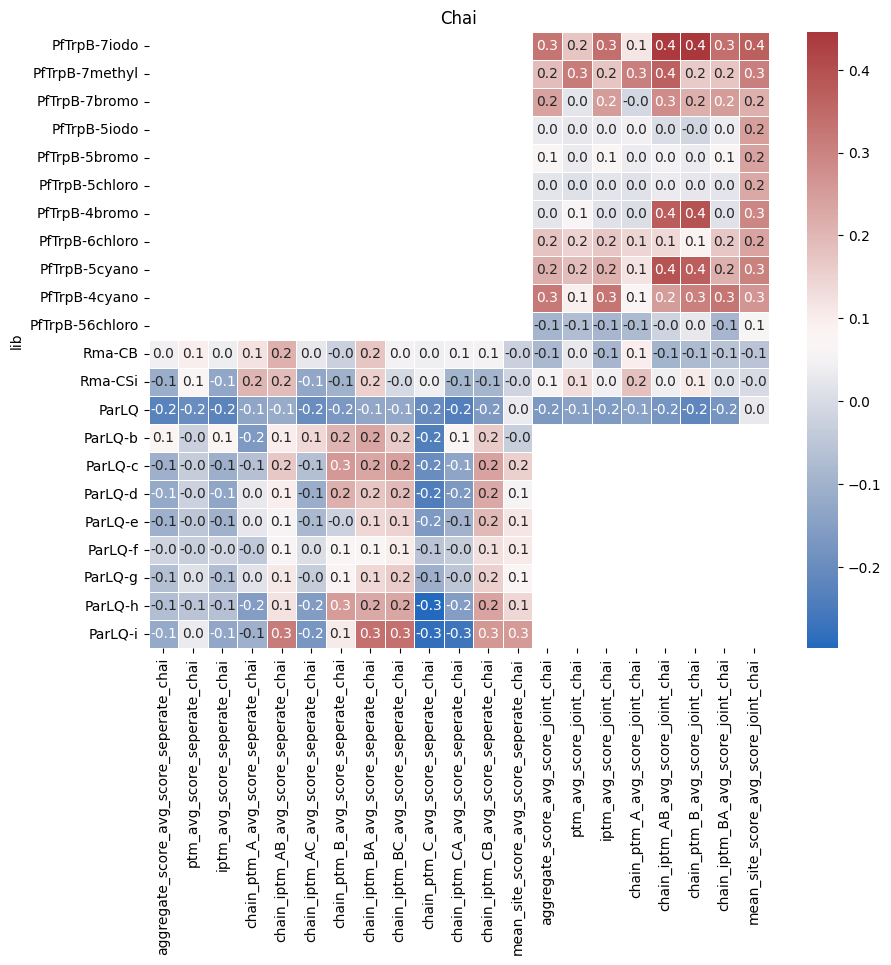

In [9]:
chai_df = (
    df_rho_fit[
        [
            "lib",
            "aggregate_score_avg_score_seperate_chai",
            "ptm_avg_score_seperate_chai",
            "iptm_avg_score_seperate_chai",
            "chain_ptm_A_avg_score_seperate_chai",
            "chain_iptm_AB_avg_score_seperate_chai",
            "chain_iptm_AC_avg_score_seperate_chai",
            "chain_ptm_B_avg_score_seperate_chai",
            "chain_iptm_BA_avg_score_seperate_chai",
            "chain_iptm_BC_avg_score_seperate_chai",
            "chain_ptm_C_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CB_avg_score_seperate_chai",
            "mean_site_score_avg_score_seperate_chai",
            "aggregate_score_avg_score_joint_chai",
            "ptm_avg_score_joint_chai",
            "iptm_avg_score_joint_chai",
            "chain_ptm_A_avg_score_joint_chai",
            "chain_iptm_AB_avg_score_joint_chai",
            "chain_ptm_B_avg_score_joint_chai",
            "chain_iptm_BA_avg_score_joint_chai",
            "mean_site_score_avg_score_joint_chai",
        ]
    ]
    .set_index("lib")
    .reindex(custom_order)
)

# Set the figure size
plt.figure(figsize=(10, 8))

# Create a heatmap
sns.heatmap(chai_df, cmap="vlag", annot=True, fmt=".1f", linewidths=0.5)

# Show the plot
plt.title("Chai")
plt.show()

In [10]:
chai_df.mean().sort_values(ascending=False)

mean_site_score_avg_score_joint_chai       0.195523
chain_iptm_BA_avg_score_seperate_chai      0.159919
chain_iptm_AB_avg_score_joint_chai         0.147932
chain_iptm_BC_avg_score_seperate_chai      0.136940
chain_ptm_B_avg_score_joint_chai           0.133046
chain_iptm_CB_avg_score_seperate_chai      0.128219
chain_iptm_AB_avg_score_seperate_chai      0.119331
aggregate_score_avg_score_joint_chai       0.095056
iptm_avg_score_joint_chai                  0.094393
chain_iptm_BA_avg_score_joint_chai         0.093071
chain_ptm_B_avg_score_seperate_chai        0.078899
mean_site_score_avg_score_seperate_chai    0.078448
ptm_avg_score_joint_chai                   0.072293
chain_ptm_A_avg_score_joint_chai           0.065338
ptm_avg_score_seperate_chai               -0.018489
chain_ptm_A_avg_score_seperate_chai       -0.024261
chain_iptm_AC_avg_score_seperate_chai     -0.070912
aggregate_score_avg_score_seperate_chai   -0.074640
iptm_avg_score_seperate_chai              -0.077802
chain_iptm_C

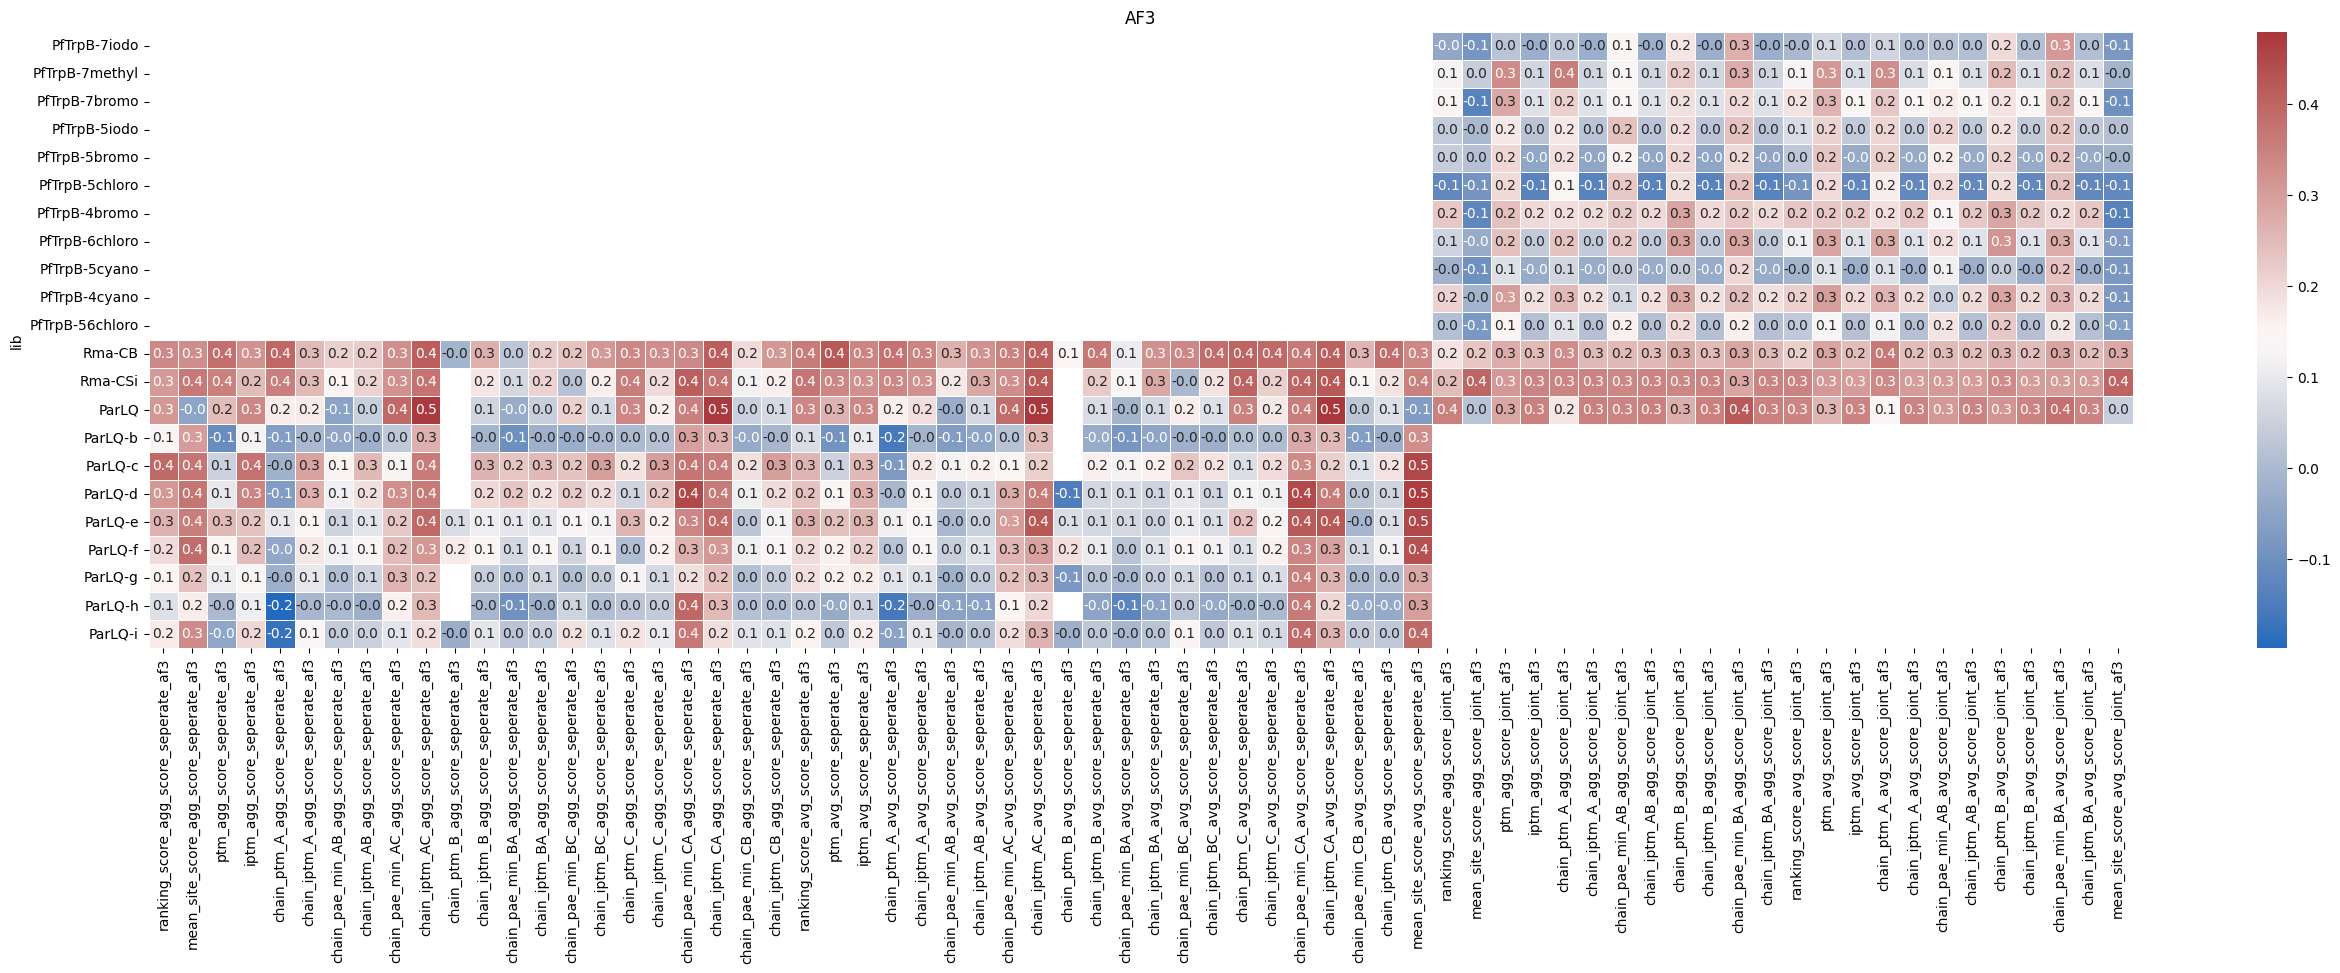

In [13]:
af3_df = (
    df_rho_fit[
        [
            "lib",
            "ranking_score_agg_score_seperate_af3",
            "mean_site_score_agg_score_seperate_af3",
            "ptm_agg_score_seperate_af3",
            "iptm_agg_score_seperate_af3",
            # "fraction_disordered_agg_score_seperate_af3",
            "chain_ptm_A_agg_score_seperate_af3",
            "chain_iptm_A_agg_score_seperate_af3",
            "chain_pae_min_AB_agg_score_seperate_af3",
            "chain_iptm_AB_agg_score_seperate_af3",
            "chain_pae_min_AC_agg_score_seperate_af3",
            "chain_iptm_AC_agg_score_seperate_af3",
            "chain_ptm_B_agg_score_seperate_af3",
            "chain_iptm_B_agg_score_seperate_af3",
            "chain_pae_min_BA_agg_score_seperate_af3",
            "chain_iptm_BA_agg_score_seperate_af3",
            "chain_pae_min_BC_agg_score_seperate_af3",
            "chain_iptm_BC_agg_score_seperate_af3",
            "chain_ptm_C_agg_score_seperate_af3",
            "chain_iptm_C_agg_score_seperate_af3",
            "chain_pae_min_CA_agg_score_seperate_af3",
            "chain_iptm_CA_agg_score_seperate_af3",
            "chain_pae_min_CB_agg_score_seperate_af3",
            "chain_iptm_CB_agg_score_seperate_af3",
            "ranking_score_avg_score_seperate_af3",
            "ptm_avg_score_seperate_af3",
            "iptm_avg_score_seperate_af3",
            # "fraction_disordered_avg_score_seperate_af3",
            "chain_ptm_A_avg_score_seperate_af3",
            "chain_iptm_A_avg_score_seperate_af3",
            "chain_pae_min_AB_avg_score_seperate_af3",
            "chain_iptm_AB_avg_score_seperate_af3",
            "chain_pae_min_AC_avg_score_seperate_af3",
            "chain_iptm_AC_avg_score_seperate_af3",
            "chain_ptm_B_avg_score_seperate_af3",
            "chain_iptm_B_avg_score_seperate_af3",
            "chain_pae_min_BA_avg_score_seperate_af3",
            "chain_iptm_BA_avg_score_seperate_af3",
            "chain_pae_min_BC_avg_score_seperate_af3",
            "chain_iptm_BC_avg_score_seperate_af3",
            "chain_ptm_C_avg_score_seperate_af3",
            "chain_iptm_C_avg_score_seperate_af3",
            "chain_pae_min_CA_avg_score_seperate_af3",
            "chain_iptm_CA_avg_score_seperate_af3",
            "chain_pae_min_CB_avg_score_seperate_af3",
            "chain_iptm_CB_avg_score_seperate_af3",
            "mean_site_score_avg_score_seperate_af3",
            "ranking_score_agg_score_joint_af3",
            "mean_site_score_agg_score_joint_af3",
            "ptm_agg_score_joint_af3",
            "iptm_agg_score_joint_af3",
            # "fraction_disordered_agg_score_joint_af3",
            "chain_ptm_A_agg_score_joint_af3",
            "chain_iptm_A_agg_score_joint_af3",
            "chain_pae_min_AB_agg_score_joint_af3",
            "chain_iptm_AB_agg_score_joint_af3",
            "chain_ptm_B_agg_score_joint_af3",
            "chain_iptm_B_agg_score_joint_af3",
            "chain_pae_min_BA_agg_score_joint_af3",
            "chain_iptm_BA_agg_score_joint_af3",
            "ranking_score_avg_score_joint_af3",
            "ptm_avg_score_joint_af3",
            "iptm_avg_score_joint_af3",
            # "fraction_disordered_avg_score_joint_af3",
            "chain_ptm_A_avg_score_joint_af3",
            "chain_iptm_A_avg_score_joint_af3",
            "chain_pae_min_AB_avg_score_joint_af3",
            "chain_iptm_AB_avg_score_joint_af3",
            "chain_ptm_B_avg_score_joint_af3",
            "chain_iptm_B_avg_score_joint_af3",
            "chain_pae_min_BA_avg_score_joint_af3",
            "chain_iptm_BA_avg_score_joint_af3",
            "mean_site_score_avg_score_joint_af3",
        ]
    ]
    .set_index("lib")
    .reindex(custom_order)
)

# Set the figure size
plt.figure(figsize=(32, 8))

# Create a heatmap
sns.heatmap(af3_df, cmap="vlag", annot=True, fmt=".1f", linewidths=0.5)

# Show the plot
plt.title("AF3")
plt.show()

In [15]:
af3_df.mean().sort_values(ascending=False)[:20]

chain_pae_min_CA_avg_score_seperate_af3    0.366314
chain_pae_min_CA_agg_score_seperate_af3    0.342143
mean_site_score_avg_score_seperate_af3     0.338127
chain_iptm_AC_agg_score_seperate_af3       0.330191
chain_iptm_CA_agg_score_seperate_af3       0.330191
chain_iptm_AC_avg_score_seperate_af3       0.324976
chain_iptm_CA_avg_score_seperate_af3       0.324976
mean_site_score_agg_score_seperate_af3     0.287421
chain_pae_min_BA_avg_score_joint_af3       0.259055
chain_pae_min_BA_agg_score_joint_af3       0.252126
iptm_agg_score_seperate_af3                0.242552
ranking_score_agg_score_seperate_af3       0.241147
chain_pae_min_AC_avg_score_seperate_af3    0.238943
chain_ptm_B_avg_score_joint_af3            0.233858
chain_pae_min_AC_agg_score_seperate_af3    0.227967
chain_ptm_B_agg_score_joint_af3            0.225707
iptm_avg_score_seperate_af3                0.225098
ptm_avg_score_joint_af3                    0.224783
ranking_score_avg_score_seperate_af3       0.224706
ptm_agg_scor

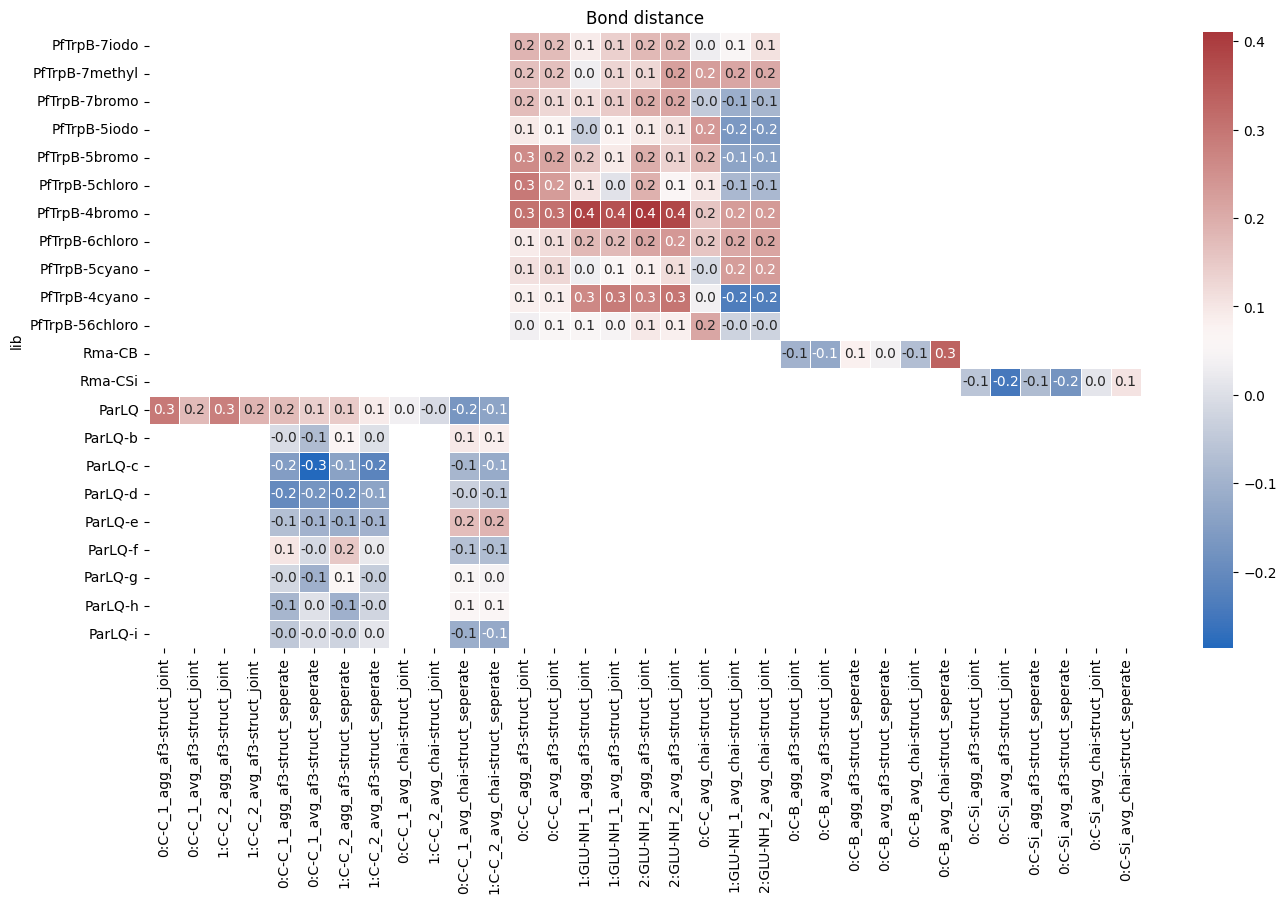

In [21]:
bond_df = (
    df_rho_fit[
        [
            "lib",
            "0:C-C_1_agg_af3-struct_joint",
            "0:C-C_1_avg_af3-struct_joint",
            "1:C-C_2_agg_af3-struct_joint",
            "1:C-C_2_avg_af3-struct_joint",
            "0:C-C_1_agg_af3-struct_seperate",
            "0:C-C_1_avg_af3-struct_seperate",
            "1:C-C_2_agg_af3-struct_seperate",
            "1:C-C_2_avg_af3-struct_seperate",
            "0:C-C_1_avg_chai-struct_joint",
            "1:C-C_2_avg_chai-struct_joint",
            "0:C-C_1_avg_chai-struct_seperate",
            "1:C-C_2_avg_chai-struct_seperate",
            "0:C-C_agg_af3-struct_joint",
            "0:C-C_avg_af3-struct_joint",
            "1:GLU-NH_1_agg_af3-struct_joint",
            "1:GLU-NH_1_avg_af3-struct_joint",
            "2:GLU-NH_2_agg_af3-struct_joint",
            "2:GLU-NH_2_avg_af3-struct_joint",
            "0:C-C_avg_chai-struct_joint",
            "1:GLU-NH_1_avg_chai-struct_joint",
            "2:GLU-NH_2_avg_chai-struct_joint",
            "0:C-B_agg_af3-struct_joint",
            "0:C-B_avg_af3-struct_joint",
            "0:C-B_agg_af3-struct_seperate",
            "0:C-B_avg_af3-struct_seperate",
            "0:C-B_avg_chai-struct_joint",
            "0:C-B_avg_chai-struct_seperate",
            "0:C-Si_agg_af3-struct_joint",
            "0:C-Si_avg_af3-struct_joint",
            "0:C-Si_agg_af3-struct_seperate",
            "0:C-Si_avg_af3-struct_seperate",
            "0:C-Si_avg_chai-struct_joint",
            "0:C-Si_avg_chai-struct_seperate",
        ]
    ]
    .set_index("lib")
    .reindex(custom_order)
)

# Set the figure size
plt.figure(figsize=(16, 8))

# Create a heatmap
sns.heatmap(bond_df, cmap="vlag", annot=True, fmt=".1f", linewidths=0.5)

# Show the plot
plt.title("Bond distance")
plt.show()

In [22]:
bond_df.mean().sort_values(ascending=False)[:10]

0:C-B_avg_chai-struct_seperate     0.333174
0:C-C_1_agg_af3-struct_joint       0.292502
1:C-C_2_agg_af3-struct_joint       0.282574
2:GLU-NH_2_agg_af3-struct_joint    0.187464
2:GLU-NH_2_avg_af3-struct_joint    0.185313
1:C-C_2_avg_af3-struct_joint       0.185062
0:C-C_1_avg_af3-struct_joint       0.176340
0:C-C_agg_af3-struct_joint         0.162838
0:C-C_avg_af3-struct_joint         0.152101
1:GLU-NH_1_avg_af3-struct_joint    0.138475
dtype: float64

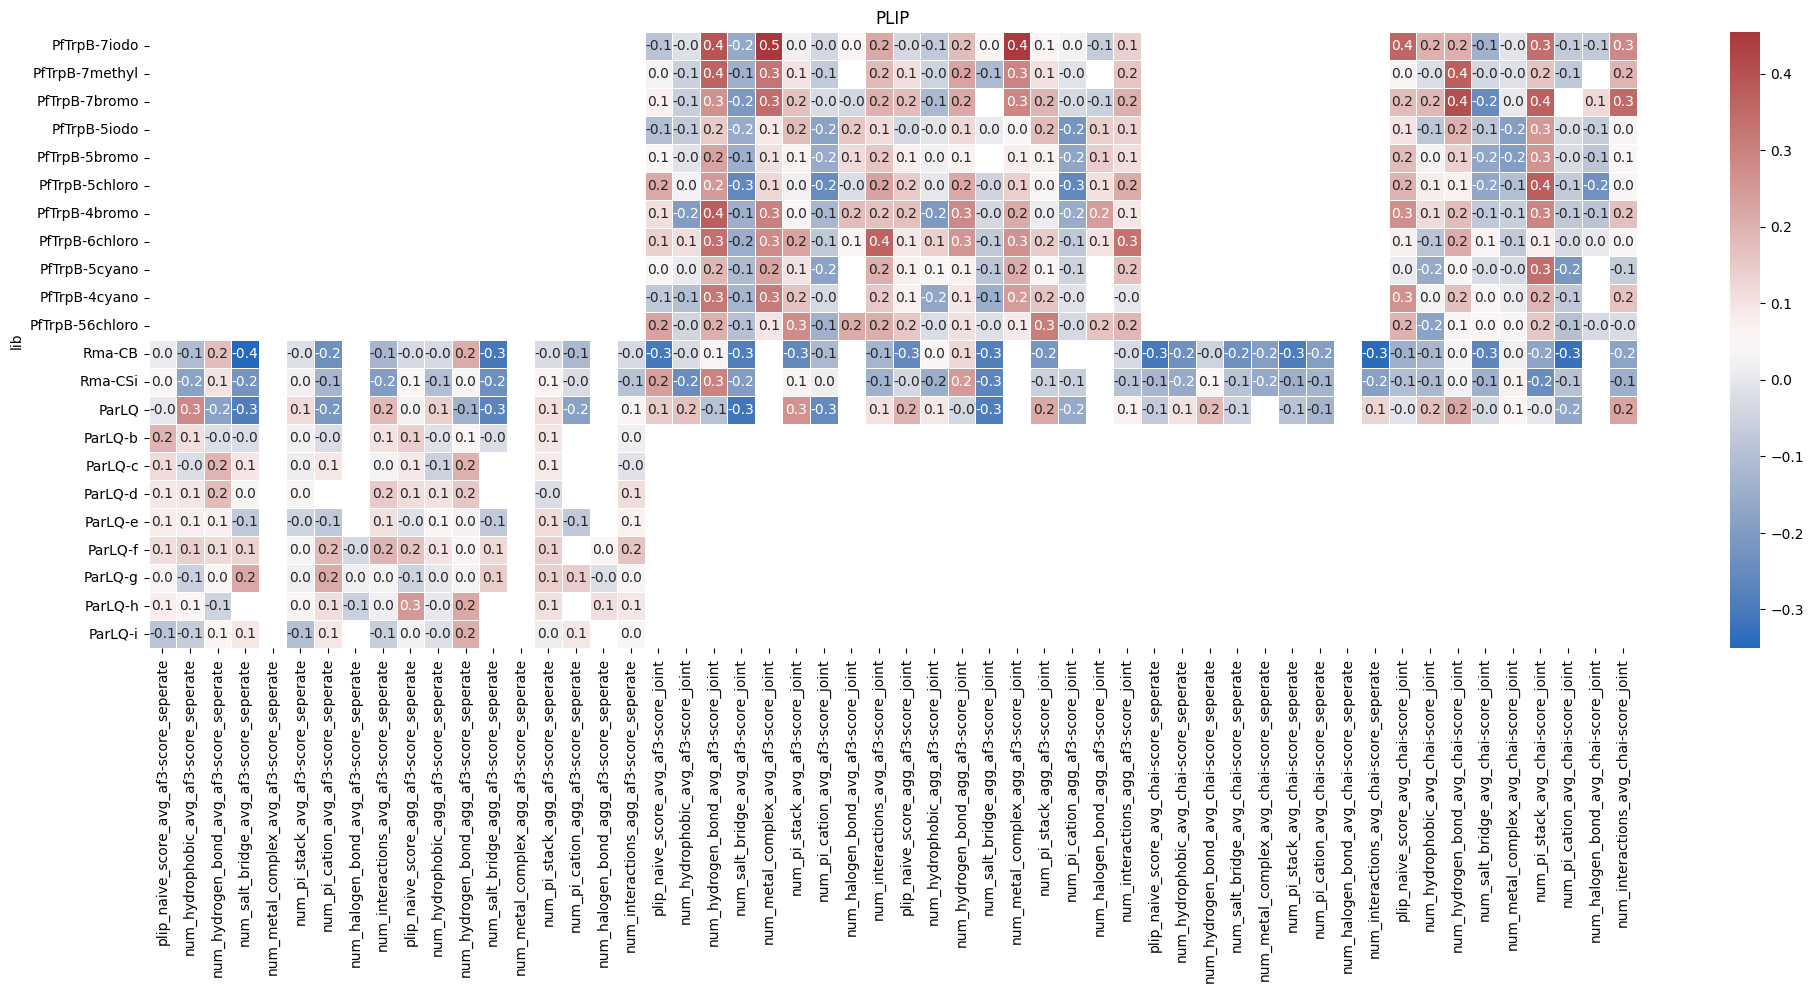

In [24]:
plip_metrics = [
    "lib",
    "plip_naive_score_avg_af3-score_seperate",
    "num_hydrophobic_avg_af3-score_seperate",
    # "sum_hydrophobic_avg_af3-score_seperate",
    "num_hydrogen_bond_avg_af3-score_seperate",
    # "sum_hydrogen_bond_avg_af3-score_seperate",
    "num_salt_bridge_avg_af3-score_seperate",
    # "sum_salt_bridge_avg_af3-score_seperate",
    "num_metal_complex_avg_af3-score_seperate",
    # "sum_metal_complex_avg_af3-score_seperate",
    "num_pi_stack_avg_af3-score_seperate",
    # "sum_pi_stack_avg_af3-score_seperate",
    "num_pi_cation_avg_af3-score_seperate",
    # "sum_pi_cation_avg_af3-score_seperate",
    "num_halogen_bond_avg_af3-score_seperate",
    # "sum_halogen_bond_avg_af3-score_seperate",
    "num_interactions_avg_af3-score_seperate",
    "plip_naive_score_agg_af3-score_seperate",
    "num_hydrophobic_agg_af3-score_seperate",
    # "sum_hydrophobic_agg_af3-score_seperate",
    "num_hydrogen_bond_agg_af3-score_seperate",
    # "sum_hydrogen_bond_agg_af3-score_seperate",
    "num_salt_bridge_agg_af3-score_seperate",
    # "sum_salt_bridge_agg_af3-score_seperate",
    "num_metal_complex_agg_af3-score_seperate",
    # "sum_metal_complex_agg_af3-score_seperate",
    "num_pi_stack_agg_af3-score_seperate",
    # "sum_pi_stack_agg_af3-score_seperate",
    "num_pi_cation_agg_af3-score_seperate",
    # "sum_pi_cation_agg_af3-score_seperate",
    "num_halogen_bond_agg_af3-score_seperate",
    # "sum_halogen_bond_agg_af3-score_seperate",
    "num_interactions_agg_af3-score_seperate",
    "plip_naive_score_avg_af3-score_joint",
    "num_hydrophobic_avg_af3-score_joint",
    # "sum_hydrophobic_avg_af3-score_joint",
    "num_hydrogen_bond_avg_af3-score_joint",
    # "sum_hydrogen_bond_avg_af3-score_joint",
    "num_salt_bridge_avg_af3-score_joint",
    # "sum_salt_bridge_avg_af3-score_joint",
    "num_metal_complex_avg_af3-score_joint",
    # "sum_metal_complex_avg_af3-score_joint",
    "num_pi_stack_avg_af3-score_joint",
    # "sum_pi_stack_avg_af3-score_joint",
    "num_pi_cation_avg_af3-score_joint",
    # "sum_pi_cation_avg_af3-score_joint",
    "num_halogen_bond_avg_af3-score_joint",
    # "sum_halogen_bond_avg_af3-score_joint",
    "num_interactions_avg_af3-score_joint",
    "plip_naive_score_agg_af3-score_joint",
    "num_hydrophobic_agg_af3-score_joint",
    # "sum_hydrophobic_agg_af3-score_joint",
    "num_hydrogen_bond_agg_af3-score_joint",
    # "sum_hydrogen_bond_agg_af3-score_joint",
    "num_salt_bridge_agg_af3-score_joint",
    # "sum_salt_bridge_agg_af3-score_joint",
    "num_metal_complex_agg_af3-score_joint",
    # "sum_metal_complex_agg_af3-score_joint",
    "num_pi_stack_agg_af3-score_joint",
    # "sum_pi_stack_agg_af3-score_joint",
    "num_pi_cation_agg_af3-score_joint",
    # "sum_pi_cation_agg_af3-score_joint",
    "num_halogen_bond_agg_af3-score_joint",
    # "sum_halogen_bond_agg_af3-score_joint",
    "num_interactions_agg_af3-score_joint",
    "plip_naive_score_avg_chai-score_seperate",
    "num_hydrophobic_avg_chai-score_seperate",
    # "sum_hydrophobic_avg_chai-score_seperate",
    "num_hydrogen_bond_avg_chai-score_seperate",
    # "sum_hydrogen_bond_avg_chai-score_seperate",
    "num_salt_bridge_avg_chai-score_seperate",
    # "sum_salt_bridge_avg_chai-score_seperate",
    "num_metal_complex_avg_chai-score_seperate",
    # "sum_metal_complex_avg_chai-score_seperate",
    "num_pi_stack_avg_chai-score_seperate",
    # "sum_pi_stack_avg_chai-score_seperate",
    "num_pi_cation_avg_chai-score_seperate",
    # "sum_pi_cation_avg_chai-score_seperate",
    "num_halogen_bond_avg_chai-score_seperate",
    # "sum_halogen_bond_avg_chai-score_seperate",
    "num_interactions_avg_chai-score_seperate",
    "plip_naive_score_avg_chai-score_joint",
    "num_hydrophobic_avg_chai-score_joint",
    # "sum_hydrophobic_avg_chai-score_joint",
    "num_hydrogen_bond_avg_chai-score_joint",
    # "sum_hydrogen_bond_avg_chai-score_joint",
    "num_salt_bridge_avg_chai-score_joint",
    # "sum_salt_bridge_avg_chai-score_joint",
    "num_metal_complex_avg_chai-score_joint",
    # "sum_metal_complex_avg_chai-score_joint",
    "num_pi_stack_avg_chai-score_joint",
    # "sum_pi_stack_avg_chai-score_joint",
    "num_pi_cation_avg_chai-score_joint",
    # "sum_pi_cation_avg_chai-score_joint",
    "num_halogen_bond_avg_chai-score_joint",
    # "sum_halogen_bond_avg_chai-score_joint",
    "num_interactions_avg_chai-score_joint"
]

plip_df = df_rho_fit[plip_metrics].set_index("lib").reindex(custom_order)

# Set the figure size
plt.figure(figsize=(24, 8))

# Create a heatmap
sns.heatmap(plip_df, cmap="vlag", annot=True, fmt=".1f", linewidths=0.5)

# Show the plot
plt.title("PLIP")
plt.show()

In [26]:
plip_df.mean().sort_values(ascending=False)[:16]

num_metal_complex_avg_af3-score_joint       0.242016
num_hydrogen_bond_avg_af3-score_joint       0.238973
num_metal_complex_agg_af3-score_joint       0.210913
num_pi_stack_avg_chai-score_joint           0.171691
num_hydrogen_bond_avg_chai-score_joint      0.167127
num_hydrogen_bond_agg_af3-score_joint       0.156176
num_interactions_avg_af3-score_joint        0.146445
num_interactions_agg_af3-score_joint        0.120545
plip_naive_score_avg_chai-score_joint       0.115248
num_pi_stack_avg_af3-score_joint            0.103638
num_halogen_bond_agg_af3-score_joint        0.097520
num_hydrogen_bond_agg_af3-score_seperate    0.093983
num_pi_stack_agg_af3-score_joint            0.090524
num_halogen_bond_avg_af3-score_joint        0.089009
num_interactions_avg_chai-score_joint       0.083275
num_pi_stack_agg_af3-score_seperate         0.073824
dtype: float64

In [14]:
[c for c in parlqb.columns if "vina" in c]

['vina_af3-score_seperate-substrate_cofactor-score_only',
 'vina_min_af3-score_seperate-substrate_cofactor-score_only',
 'vina_max_af3-score_seperate-substrate_cofactor-score_only',
 'vina_apo-score-substrate_cofactor-docked',
 'vina_min_apo-score-substrate_cofactor-docked',
 'vina_max_apo-score-substrate_cofactor-docked',
 'vina_chai-score_seperate-substrate_cofactor-score_only',
 'vina_min_chai-score_seperate-substrate_cofactor-score_only',
 'vina_max_chai-score_seperate-substrate_cofactor-score_only']

Text(0.5, 1.0, 'Vina')

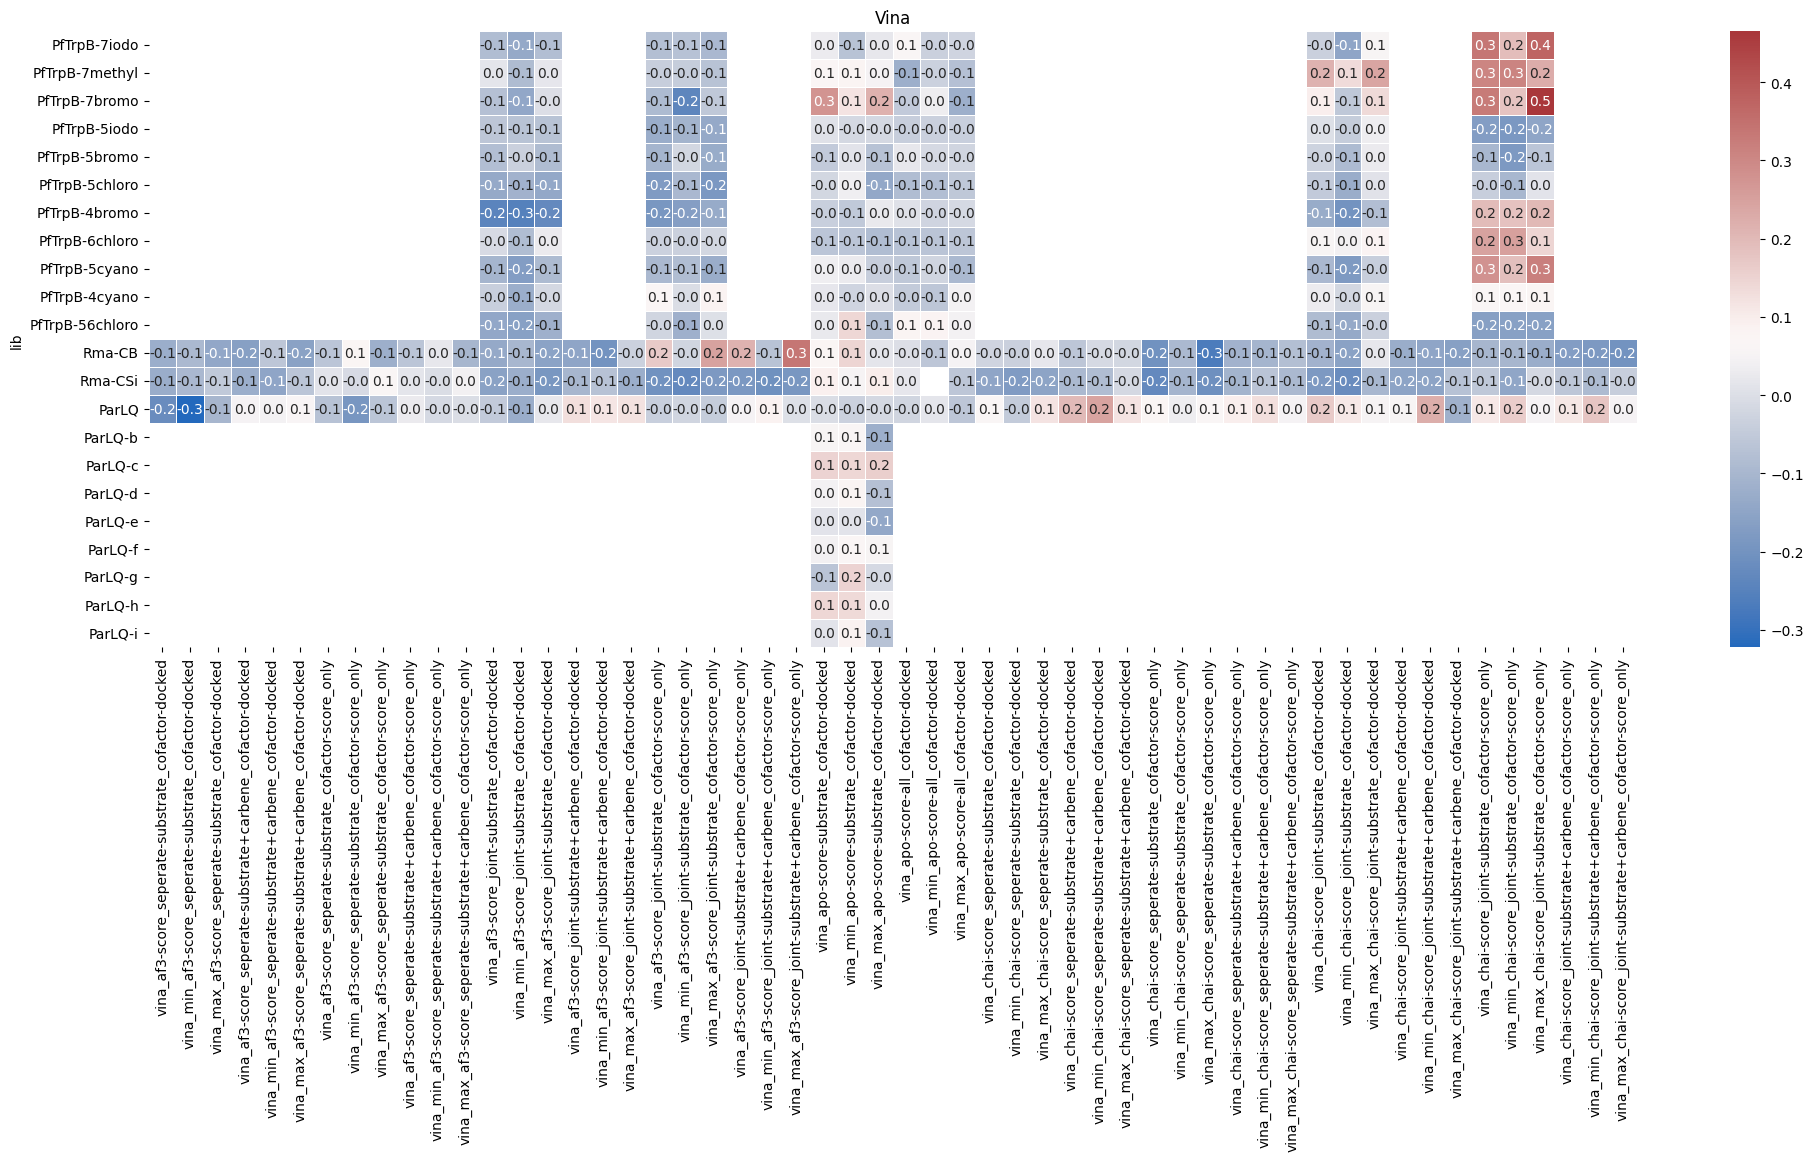

In [15]:
vina_cols = [
    "lib",
    "vina_af3-score_seperate-substrate_cofactor-docked",
    "vina_min_af3-score_seperate-substrate_cofactor-docked",
    "vina_max_af3-score_seperate-substrate_cofactor-docked",
    "vina_af3-score_seperate-substrate+carbene_cofactor-docked",
    "vina_min_af3-score_seperate-substrate+carbene_cofactor-docked",
    "vina_max_af3-score_seperate-substrate+carbene_cofactor-docked",
    "vina_af3-score_seperate-substrate_cofactor-score_only",
    "vina_min_af3-score_seperate-substrate_cofactor-score_only",
    "vina_max_af3-score_seperate-substrate_cofactor-score_only",
    "vina_af3-score_seperate-substrate+carbene_cofactor-score_only",
    "vina_min_af3-score_seperate-substrate+carbene_cofactor-score_only",
    "vina_max_af3-score_seperate-substrate+carbene_cofactor-score_only",
    "vina_af3-score_joint-substrate_cofactor-docked",
    "vina_min_af3-score_joint-substrate_cofactor-docked",
    "vina_max_af3-score_joint-substrate_cofactor-docked",
    "vina_af3-score_joint-substrate+carbene_cofactor-docked",
    "vina_min_af3-score_joint-substrate+carbene_cofactor-docked",
    "vina_max_af3-score_joint-substrate+carbene_cofactor-docked",
    "vina_af3-score_joint-substrate_cofactor-score_only",
    "vina_min_af3-score_joint-substrate_cofactor-score_only",
    "vina_max_af3-score_joint-substrate_cofactor-score_only",
    "vina_af3-score_joint-substrate+carbene_cofactor-score_only",
    "vina_min_af3-score_joint-substrate+carbene_cofactor-score_only",
    "vina_max_af3-score_joint-substrate+carbene_cofactor-score_only",
    "vina_apo-score-substrate_cofactor-docked",
    "vina_min_apo-score-substrate_cofactor-docked",
    "vina_max_apo-score-substrate_cofactor-docked",
    "vina_apo-score-all_cofactor-docked",
    "vina_min_apo-score-all_cofactor-docked",
    "vina_max_apo-score-all_cofactor-docked",
    "vina_chai-score_seperate-substrate_cofactor-docked",
    "vina_min_chai-score_seperate-substrate_cofactor-docked",
    "vina_max_chai-score_seperate-substrate_cofactor-docked",
    "vina_chai-score_seperate-substrate+carbene_cofactor-docked",
    "vina_min_chai-score_seperate-substrate+carbene_cofactor-docked",
    "vina_max_chai-score_seperate-substrate+carbene_cofactor-docked",
    "vina_chai-score_seperate-substrate_cofactor-score_only",
    "vina_min_chai-score_seperate-substrate_cofactor-score_only",
    "vina_max_chai-score_seperate-substrate_cofactor-score_only",
    "vina_chai-score_seperate-substrate+carbene_cofactor-score_only",
    "vina_min_chai-score_seperate-substrate+carbene_cofactor-score_only",
    "vina_max_chai-score_seperate-substrate+carbene_cofactor-score_only",
    "vina_chai-score_joint-substrate_cofactor-docked",
    "vina_min_chai-score_joint-substrate_cofactor-docked",
    "vina_max_chai-score_joint-substrate_cofactor-docked",
    "vina_chai-score_joint-substrate+carbene_cofactor-docked",
    "vina_min_chai-score_joint-substrate+carbene_cofactor-docked",
    "vina_max_chai-score_joint-substrate+carbene_cofactor-docked",
    "vina_chai-score_joint-substrate_cofactor-score_only",
    "vina_min_chai-score_joint-substrate_cofactor-score_only",
    "vina_max_chai-score_joint-substrate_cofactor-score_only",
    "vina_chai-score_joint-substrate+carbene_cofactor-score_only",
    "vina_min_chai-score_joint-substrate+carbene_cofactor-score_only",
    "vina_max_chai-score_joint-substrate+carbene_cofactor-score_only"
]
vina_df = df_rho_fit[vina_cols].set_index("lib").reindex(custom_order)

# Set the figure size
plt.figure(figsize=(24, 8))
# Create a heatmap
sns.heatmap(vina_df, cmap="vlag", annot=True, fmt=".1f", linewidths=0.5)
# Show the plot
plt.title("Vina")

In [8]:
vina_df.mean().sort_values(ascending=False)[:16]

vina_max_chai-score_joint-substrate_cofactor-score_only              0.096372
vina_chai-score_joint-substrate_cofactor-score_only                  0.088187
vina_max_af3-score_joint-substrate+carbene_cofactor-score_only       0.050933
vina_min_apo-score-substrate_cofactor-docked                         0.049637
vina_min_chai-score_seperate-substrate+carbene_cofactor-docked       0.049318
vina_min_chai-score_joint-substrate_cofactor-score_only              0.046765
vina_apo-score-substrate_cofactor-docked                             0.037751
vina_max_chai-score_joint-substrate_cofactor-docked                  0.032554
vina_max_chai-score_seperate-substrate+carbene_cofactor-docked       0.027470
vina_af3-score_joint-substrate+carbene_cofactor-score_only           0.025905
vina_chai-score_seperate-substrate+carbene_cofactor-docked           0.014973
vina_min_af3-score_seperate-substrate+carbene_cofactor-score_only    0.001151
vina_max_chai-score_seperate-substrate_cofactor-docked          

Text(0.5, 1.0, 'Hydro')

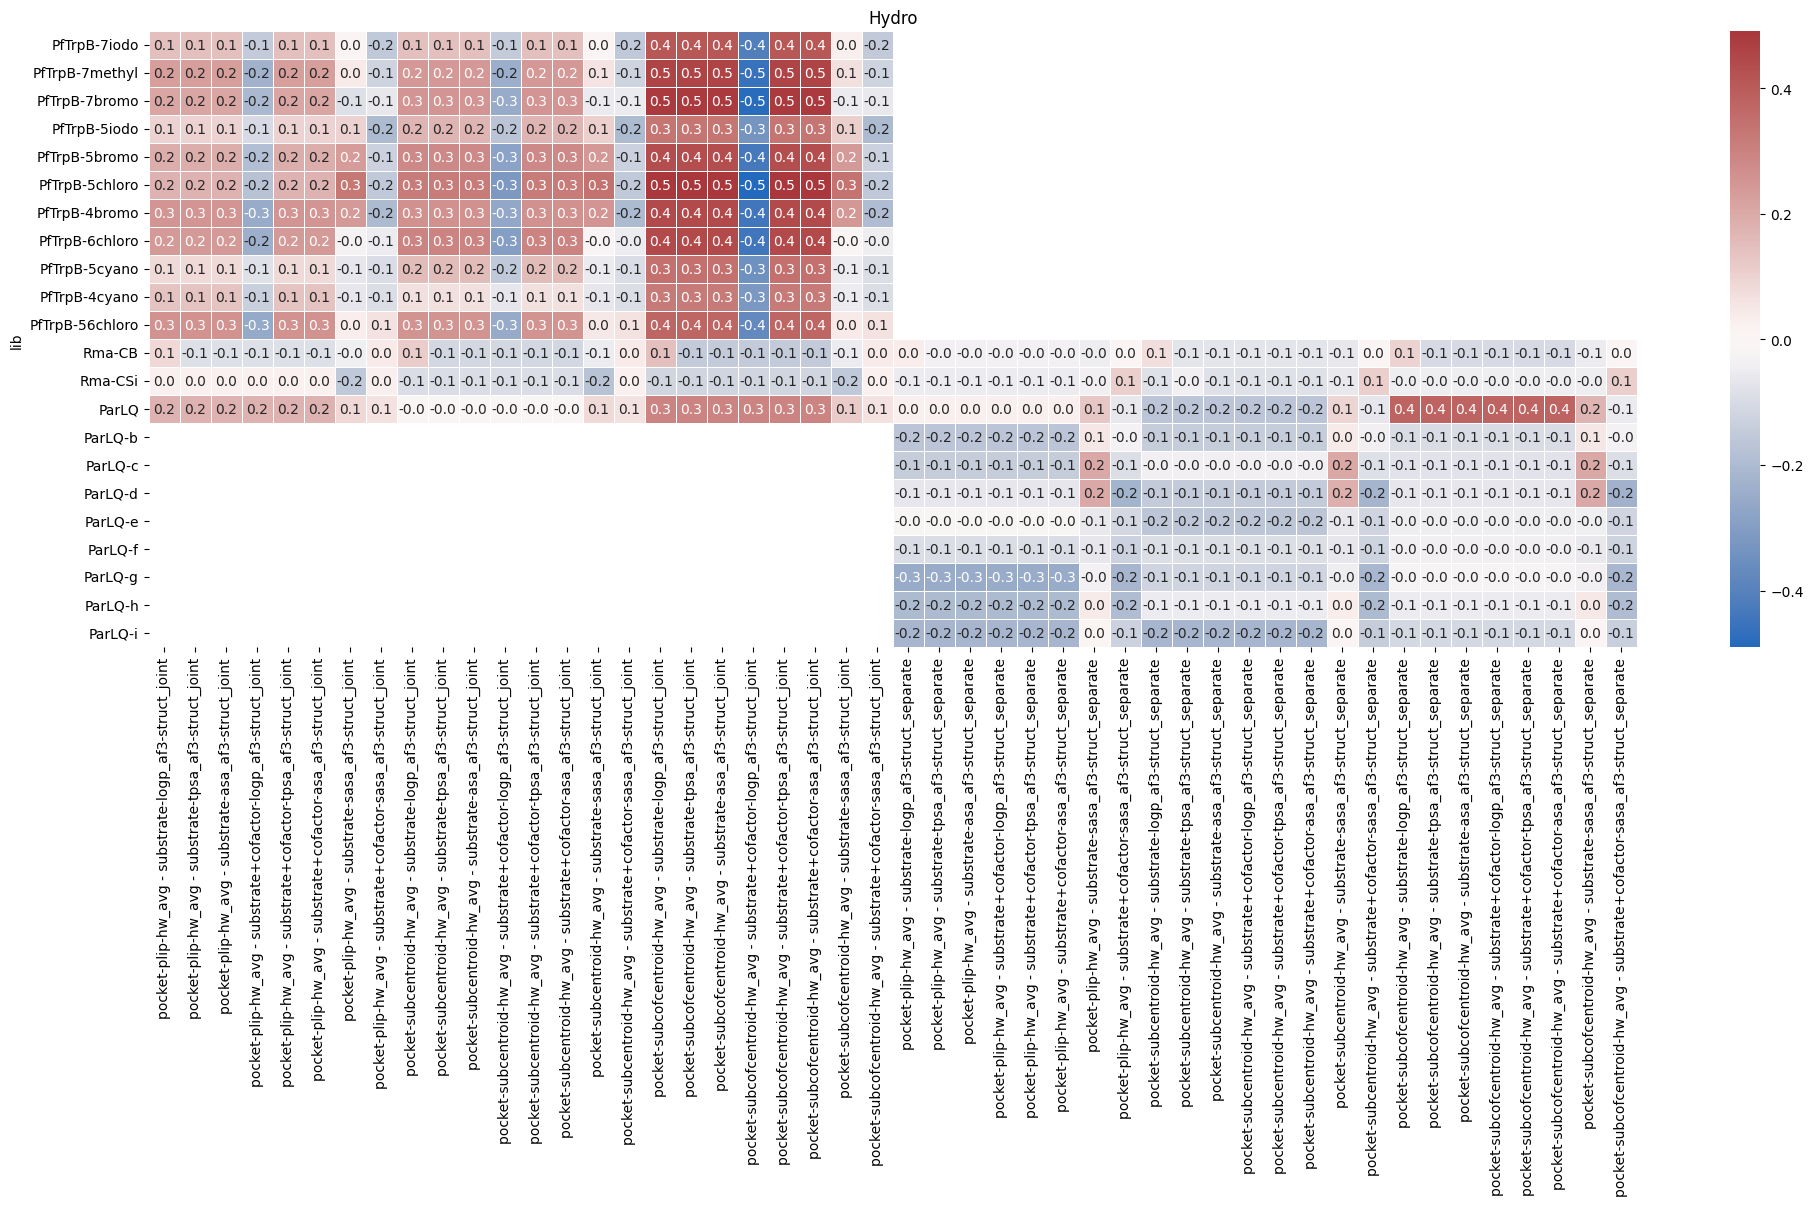

In [70]:
hydro_cols = [c for c in df_rho_fit.columns if " - " in c and "_avg" in c and "-hw" in c]
hydro_df = df_rho_fit[["lib"] + hydro_cols].set_index("lib").reindex(custom_order)

# Set the figure size
plt.figure(figsize=(24, 8))
# Create a heatmap
sns.heatmap(hydro_df, cmap="vlag", annot=True, fmt=".1f", linewidths=0.5)
# Show the plot
plt.title("Hydro")

In [71]:
hydro_df.mean().sort_values(ascending=False)[:20]

pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_joint             0.347928
pocket-subcofcentroid-hw_avg - substrate-asa_af3-struct_joint              0.326645
pocket-subcofcentroid-hw_avg - substrate-tpsa_af3-struct_joint             0.326645
pocket-subcofcentroid-hw_avg - substrate+cofactor-asa_af3-struct_joint     0.326645
pocket-subcofcentroid-hw_avg - substrate+cofactor-tpsa_af3-struct_joint    0.326645
pocket-subcentroid-hw_avg - substrate-logp_af3-struct_joint                0.175470
pocket-plip-hw_avg - substrate-logp_af3-struct_joint                       0.165057
pocket-subcentroid-hw_avg - substrate-asa_af3-struct_joint                 0.159489
pocket-subcentroid-hw_avg - substrate+cofactor-tpsa_af3-struct_joint       0.159489
pocket-subcentroid-hw_avg - substrate+cofactor-asa_af3-struct_joint        0.159489
pocket-subcentroid-hw_avg - substrate-tpsa_af3-struct_joint                0.159466
pocket-plip-hw_avg - substrate+cofactor-asa_af3-struct_joint               0

Text(0.5, 1.0, 'GALigandDock')

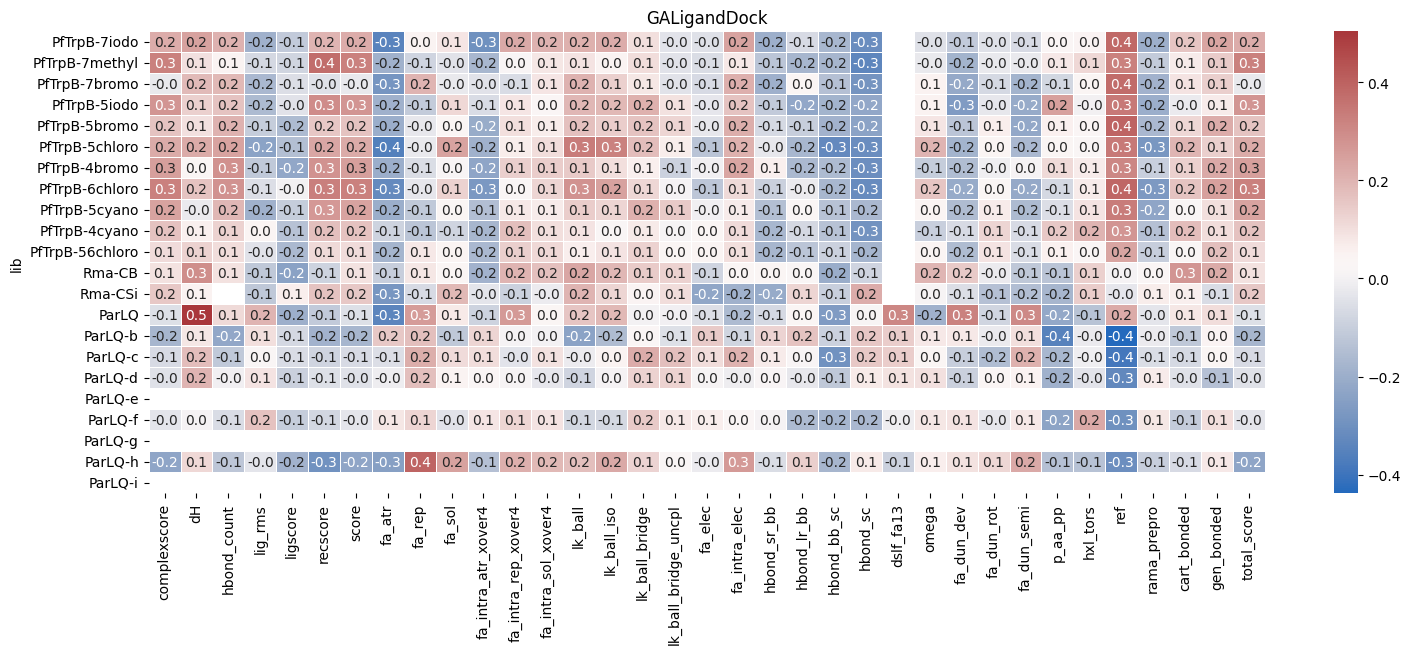

In [17]:
rosetta_cols = [
    "complexscore", "dH", "hbond_count", "lig_rms", "ligscore", 
     "recscore", "score", "fa_atr", "fa_rep", "fa_sol", 
    "fa_intra_atr_xover4", "fa_intra_rep_xover4", "fa_intra_sol_xover4", "lk_ball", 
    "lk_ball_iso", "lk_ball_bridge", "lk_ball_bridge_uncpl", "fa_elec", "fa_intra_elec", 
    "hbond_sr_bb", "hbond_lr_bb", "hbond_bb_sc", "hbond_sc", "dslf_fa13", "omega", 
    "fa_dun_dev", "fa_dun_rot", "fa_dun_semi", "p_aa_pp", "hxl_tors", "ref", 
    "rama_prepro", "cart_bonded", "gen_bonded", "total_score"
]

rosetta_df = df_rho_fit[["lib"] + rosetta_cols].set_index("lib").reindex(custom_order)

# Set the figure size
plt.figure(figsize=(18, 6))
# Create a heatmap
sns.heatmap(rosetta_df, cmap="vlag", annot=True, fmt=".1f", linewidths=0.5)
# Show the plot
plt.title("GALigandDock")

In [19]:
rosetta_df.mean().sort_values(ascending=False)[:10]

dH                0.146417
lk_ball           0.120077
lk_ball_bridge    0.119771
lk_ball_iso       0.115077
gen_bonded        0.114523
ref               0.112904
complexscore      0.100595
score             0.100595
total_score       0.100591
dslf_fa13         0.096849
dtype: float64

Text(0.5, 1.0, 'Vol')

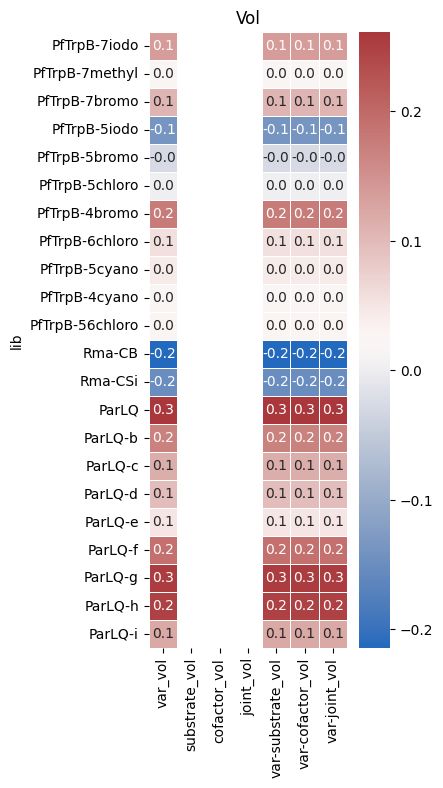

In [38]:
vol_cols = [c for c in df_rho_fit.columns if "_vol" in c]

vol_df = df_rho_fit[["lib"] + vol_cols].set_index("lib").reindex(custom_order)

# Set the figure size
plt.figure(figsize=(3.2, 8))
# Create a heatmap
sns.heatmap(vol_df, cmap="vlag", annot=True, fmt=".1f", linewidths=0.5)
# Show the plot
plt.title("Vol")

In [23]:
custom_order[-9:]

['ParLQ',
 'ParLQ-b',
 'ParLQ-c',
 'ParLQ-d',
 'ParLQ-e',
 'ParLQ-f',
 'ParLQ-g',
 'ParLQ-h',
 'ParLQ-i']

In [56]:
common_cols = [
    "lib",
    "hd",
    "ev_score",
    "esm_score",
    "esmif_score_apo-score",
    "coves_score_apo_clean-output-100_processed",
    "Triad_score_score-frompdb-cleanup",
    "ligandmpnn_score",
    "flowsite_score",
    "dH", # "complexscore",
    "vina_apo-score-substrate_cofactor-docked",
    "var_vol",
]
common_heme_col = common_cols + [
    "chain_iptm_BA_avg_score_seperate_chai",
    "chain_pae_min_CA_avg_score_seperate_af3",
    "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_separate",
    "num_hydrogen_bond_avg_af3-score_seperate",
    # "num_interactions_avg_af3-score_seperate"
]


common_col_dict = {
    "lib": "Library",
    "hd": "Hamming distance",
    "ev_score": "EVmutation",
    "esm_score": "ESM2",
    "esmif_score_apo-score": "ESM-IF",
    "coves_score_apo_clean-output-100_processed": "CoVES",
    "Triad_score_score-frompdb-cleanup": "ΔΔG",
    "ligandmpnn_score": "LigandMPNN",
    "flowsite_score": "FlowSite",
    "dH": "GALigandDock",
    # "complexscore": "GALigandock",
    "vina_apo-score-substrate_cofactor-docked": "Vina",
    "var_vol": "Active site volume",
}
common_heme_col_dict = {
    **common_col_dict,
    "chain_iptm_BA_avg_score_seperate_chai": "Chai",
    "chain_pae_min_CA_avg_score_seperate_af3": "AF3",
    "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_separate": "Hydrophobicity",
    "num_hydrogen_bond_avg_af3-score_seperate": "Hydrogen bonds",
    # "num_interactions_avg_af3-score_seperate": "PLIP",
}

In [60]:
trpb_cols = common_cols + [
    "chain_iptm_AB_avg_score_joint_chai",
    "chain_pae_min_BA_avg_score_joint_af3",
    "2:GLU-NH_2_avg_af3-struct_joint",
    "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_joint",
    "num_hydrogen_bond_avg_af3-score_joint",
    # "num_interactions_avg_af3-score_joint"
]

trpb_col_dict = {
    **common_col_dict,
    "chain_iptm_AB_avg_score_joint_chai": "Chai",
    "chain_pae_min_BA_avg_score_joint_af3": "AF3",
    "2:GLU-NH_2_avg_af3-struct_joint": "Bond distance",
    "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_joint": "Hydrophobicity",
    "num_hydrogen_bond_avg_af3-score_joint": "Hydrogen bonds",
    # "num_interactions_avg_af3-score_joint": "PLIP",
}

parlq_cols = common_heme_col + ["0:C-C_1_avg_af3-struct_seperate"]

parlq_col_dict = {
    **common_heme_col_dict,
    "0:C-C_1_avg_af3-struct_seperate": "Bond distance",
}

cb_col = common_heme_col + ["0:C-B_avg_af3-struct_seperate"]

cb_col_dict = {**common_heme_col_dict, "0:C-B_avg_af3-struct_seperate": "Bond distance"}

csi_col = common_heme_col + ["0:C-Si_avg_af3-struct_seperate"]
csi_col_dict = {
    **common_heme_col_dict,
    "0:C-Si_avg_af3-struct_seperate": "Bond distance",
}

final_col_order = [
            "Library",
            "Hamming distance",
            "EVmutation",
            "ESM2",
            "ESM-IF",
            "CoVES",
            "ΔΔG",
            "LigandMPNN",
            "FlowSite",
            "Chai",
            "AF3",
            "GALigandDock",
            "Vina",
            "Bond distance",
            "Hydrogen bonds",
            # "PLIP",
            "Hydrophobicity",
            "Active site volume",
        ]

In [61]:
trpb_rho_df = df_rho_fit[df_rho_fit["lib"].isin(custom_order[:11])].copy()
trpb_rho_df = (
    trpb_rho_df[trpb_cols].rename(columns=trpb_col_dict).copy().reset_index(drop=True)
)

# rename the lib to be PfTrpB
trpbmean = trpb_rho_df.set_index("Library").mean().to_frame().T
trpbmean["Library"] = "PfTrpB-avg"
trpbmean = trpbmean[["Library"] + trpbmean.columns.tolist()[:-1]].reset_index(drop=True)

parlq_rho_df = df_rho_fit[
    df_rho_fit["lib"].isin(custom_order[-9:])
].copy()  # df_rho_fit[df_rho_fit["lib"] == "ParLQ"].copy()
parlq_rho_df = (
    parlq_rho_df[parlq_cols]
    .rename(columns=parlq_col_dict)
    .copy()
    .reset_index(drop=True)
)

parlqmean = parlq_rho_df.set_index("Library").mean().to_frame().T
parlqmean["Library"] = "ParLQ-avg"
parlqmean = parlqmean[["Library"] + parlqmean.columns.tolist()[:-1]].reset_index(
    drop=True
)

cb_df = df_rho_fit[df_rho_fit["lib"] == "Rma-CB"].copy()
cb_df = cb_df[cb_col].rename(columns=cb_col_dict).copy().reset_index(drop=True)

csi_df = df_rho_fit[df_rho_fit["lib"] == "Rma-CSi"].copy()
csi_df = csi_df[csi_col].rename(columns=csi_col_dict).copy().reset_index(drop=True)

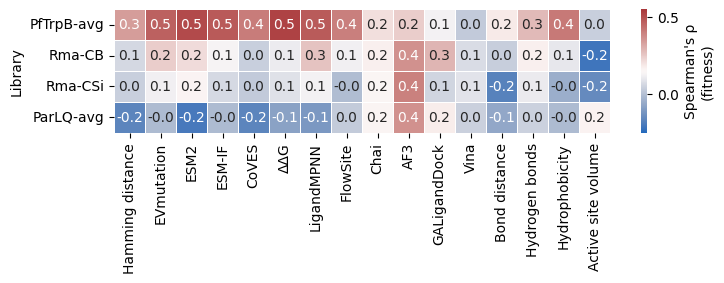

In [62]:

# Set the figure size
plt.figure(figsize=(8, 1.6))
# Create a heatmap
sns.heatmap(
    pd.concat([trpbmean, cb_df, csi_df, parlqmean])[final_col_order]
    .set_index("Library")
    .reindex(["PfTrpB-avg", "Rma-CB", "Rma-CSi", "ParLQ-avg"]),
    cmap="vlag",
    annot=True,
    fmt=".1f",
    linewidths=0.5,
    cbar_kws={"label": "Spearman's ρ\n(fitness)", "ticks": [0, 0.5]},
    vmin=-0.25,
    vmax=0.55
)
# Show the plot
# plt.title("ZS Summary: Spearman correlation")
plt.savefig("figs/zs_sum_fit_rho.svg", format="svg", dpi=300, bbox_inches="tight")

Text(0.5, 1.0, 'ZS Summary: Spearman correlation')

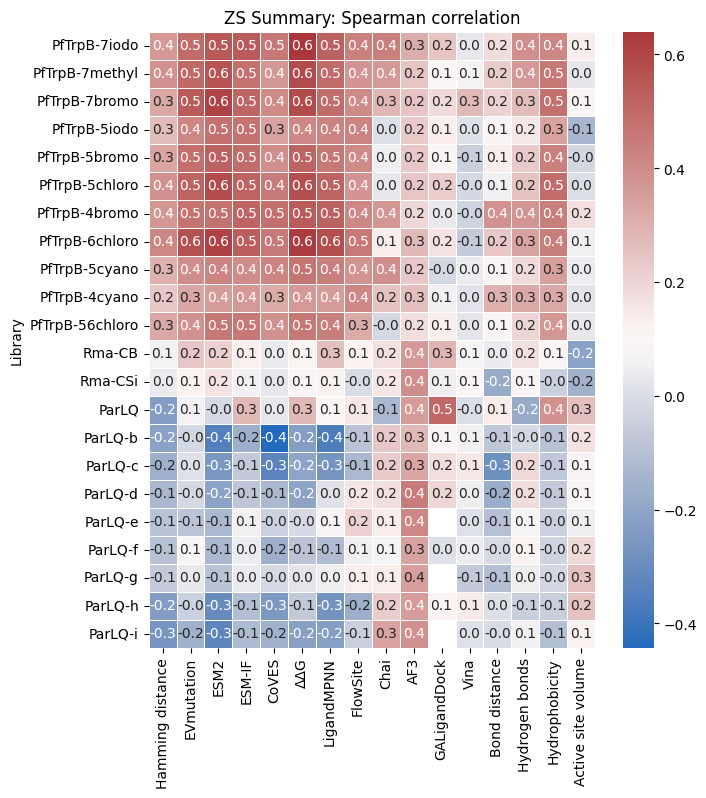

In [63]:
# Set the figure size
plt.figure(figsize=(7.2, 8))
# Create a heatmap
sns.heatmap(
    pd.concat([trpb_rho_df, cb_df, csi_df, parlq_rho_df])[final_col_order]
    .set_index("Library")
    .reindex(custom_order),
    cmap="vlag",
    annot=True,
    fmt=".1f",
    linewidths=0.5,
)
# Show the plot
plt.title("ZS Summary: Spearman correlation")

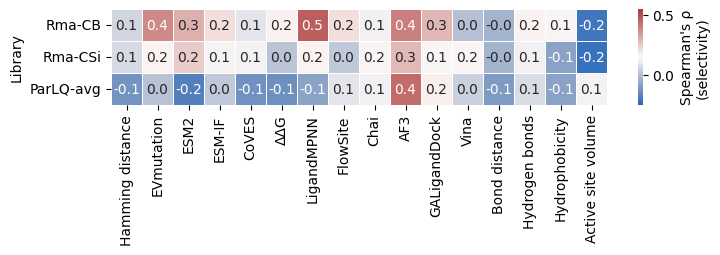

In [64]:
parlq_rho_df = df_rho_sele[df_rho_sele["lib"].isin(custom_order[-9:])].copy()# df_rho_fit[df_rho_fit["lib"] == "ParLQ"].copy()
parlq_rho_df = (
    parlq_rho_df[parlq_cols]
    .rename(
        columns=parlq_col_dict
    )
    .copy()
    .reset_index(drop=True)
)

parlqmean = parlq_rho_df.set_index("Library").mean().to_frame().T
parlqmean["Library"] = "ParLQ-avg"
parlqmean = parlqmean[["Library"] + parlqmean.columns.tolist()[:-1]].reset_index(drop=True)

cb_df = df_rho_sele[df_rho_sele["lib"] == "Rma-CB"].copy()
cb_df = (
    cb_df[
        cb_col
    ]
    .rename(
        columns=cb_col_dict
    )
    .copy()
    .reset_index(drop=True)
)

csi_df = df_rho_sele[df_rho_sele["lib"] == "Rma-CSi"].copy()
csi_df = (
    csi_df[
        csi_col
    ]
    .rename(
        columns=csi_col_dict
    )
    .copy()
    .reset_index(drop=True)
)

# Set the figure size
plt.figure(figsize=(8, 1.24))
# Create a heatmap
sns.heatmap(
    pd.concat([cb_df, csi_df, parlqmean])[final_col_order]
    .set_index("Library")
    .reindex(["Rma-CB", "Rma-CSi", "ParLQ-avg"]),
    cmap="vlag",
    annot=True,
    fmt=".1f",
    linewidths=0.5,
    vmin=-0.25,
    vmax=0.55,
    # set color bar min and max
    cbar_kws={"label": "Spearman's ρ\n(selectivity)"},
)
# Show the plot
# plt.title("ZS Summary: Spearman correlation for selectivity")
plt.savefig("figs/zs_sum_sele_rho.svg", format="svg", dpi=300, bbox_inches="tight")

Text(0.5, 1.0, 'ZS Summary: Spearman correlation for selectivity')

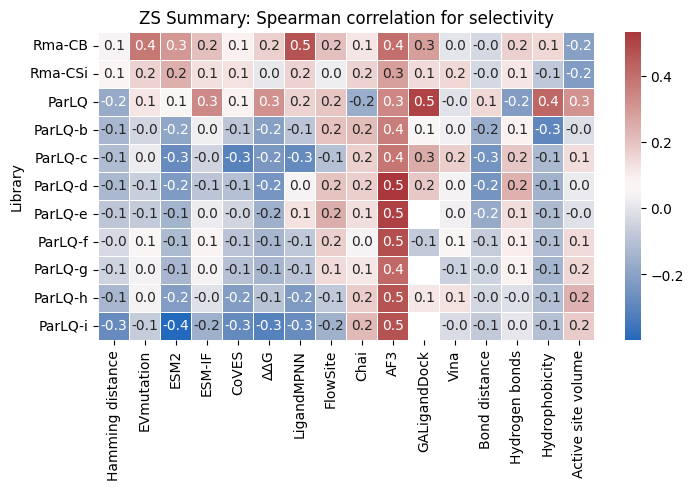

In [65]:

# Set the figure size
plt.figure(figsize=(8, 4))
# Create a heatmap
sns.heatmap(
    pd.concat([cb_df, csi_df, parlq_rho_df])[final_col_order]
    .set_index("Library")
    .reindex(custom_order[-11:]),
    cmap="vlag",
    annot=True,
    fmt=".1f",
    linewidths=0.5,
)
# Show the plot
plt.title("ZS Summary: Spearman correlation for selectivity")

In [67]:
df_rho_fit[["lib", "selectivity"]]

lib  selectivity
0             ParLQ     0.961007
1      PfTrpB-5iodo          NaN
2     PfTrpB-5bromo          NaN
3     PfTrpB-5cyano          NaN
4           ParLQ-c     0.933491
5           ParLQ-g     0.709738
6   PfTrpB-56chloro          NaN
7           ParLQ-i     0.761773
8           ParLQ-d     0.932596
9    PfTrpB-6chloro          NaN
10          ParLQ-f     0.819749
11    Rma-CSi_scope          NaN
12           Rma-CB     0.643717
13          ParLQ-b     0.752707
14          Rma-CSi     0.455375
15     Rma-CB_scope     0.531697
16    PfTrpB-4cyano          NaN
17    PfTrpB-4bromo          NaN
18     PfTrpB_scope          NaN
19          ParLQ-e     0.897093
20     PfTrpB-7iodo          NaN
21   PfTrpB-7methyl          NaN
22    PfTrpB-7bromo          NaN
23          ParLQ-h     0.925651
24   PfTrpB-5chloro          NaN

Text(0.5, 1.0, 'ZS Summary: top 50% recall')

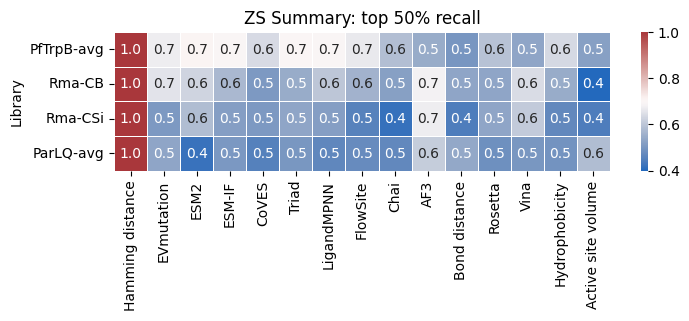

In [18]:
trpb_rho_df = df_top50_fit[df_top50_fit["lib"].isin(custom_order[:11])].copy()
trpb_rho_df = (
    trpb_rho_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_AB_avg_score_joint_chai",
            "chain_iptm_AB_avg_score_joint_af3",
            "1:GLU-NH_1_avg_chai-struct_joint",
            # "1:GLU-NH_1_avg_af3-struct_joint",
            "ligandmpnn_score",
            "flowsite_score",
            "complexscore",
            "vina_apo-score-substrate_cofactor-docked",
            "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_joint",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_AB_avg_score_joint_chai": "Chai",
            "chain_iptm_AB_avg_score_joint_af3": "AF3",
            "1:GLU-NH_1_avg_chai-struct_joint": "Bond distance",
            # "1:GLU-NH_1_avg_af3-struct_joint": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "complexscore": "Rosetta",
            "vina_apo-score-substrate_cofactor-docked": "Vina",
            "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_joint": "Hydrophobicity",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)

# rename the lib to be PfTrpB
trpbmean = trpb_rho_df.set_index("Library").mean().to_frame().T
trpbmean["Library"] = "PfTrpB-avg"
trpbmean = trpbmean[["Library"] + trpbmean.columns.tolist()[:-1]].reset_index(drop=True)

parlq_rho_df = df_top50_fit[df_top50_fit["lib"].isin(custom_order[-9:])].copy()# df_rho_fit[df_rho_fit["lib"] == "ParLQ"].copy()
parlq_rho_df = (
    parlq_rho_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_af3",
            # "0:C-C_1_avg_chai-struct_seperate",
            "0:C-C_1_avg_af3-struct_seperate",
            "ligandmpnn_score",
            "flowsite_score",
            "complexscore",
            "vina_apo-score-substrate_cofactor-docked",
            "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_separate",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_CA_avg_score_seperate_chai": "Chai",
            "chain_iptm_CA_avg_score_seperate_af3": "AF3",
            # "0:C-C_1_avg_chai-struct_seperate": "Bond distance (Chai)",
            "0:C-C_1_avg_af3-struct_seperate": "Bond distance",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "complexscore": "Rosetta",
            "vina_apo-score-substrate_cofactor-docked": "Vina",
            "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_separate": "Hydrophobicity",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)

parlqmean = parlq_rho_df.set_index("Library").mean().to_frame().T
parlqmean["Library"] = "ParLQ-avg"
parlqmean = parlqmean[["Library"] + parlqmean.columns.tolist()[:-1]].reset_index(drop=True)

cb_df = df_top50_fit[df_top50_fit["lib"] == "Rma-CB"].copy()
cb_df = (
    cb_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_af3",
            # "0:C-B_avg_chai-struct_joint",
            "0:C-B_avg_af3-struct_seperate",
            "ligandmpnn_score",
            "flowsite_score",
            "complexscore",
            "vina_apo-score-substrate_cofactor-docked",
            "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_separate",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_CA_avg_score_seperate_chai": "Chai",
            "chain_iptm_CA_avg_score_seperate_af3": "AF3",
            # "0:C-B_avg_chai-struct_joint": "Bond distance (Chai)",
            "0:C-B_avg_af3-struct_seperate": "Bond distance",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "complexscore": "Rosetta",
            "vina_apo-score-substrate_cofactor-docked": "Vina",
            "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_separate": "Hydrophobicity",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)

csi_df = df_top50_fit[df_top50_fit["lib"] == "Rma-CSi"].copy()
csi_df = (
    csi_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_af3",
            # "0:C-Si_avg_chai-struct_joint",
            "0:C-Si_avg_af3-struct_seperate",
            "ligandmpnn_score",
            "flowsite_score",
            "complexscore",
            "vina_apo-score-substrate_cofactor-docked",
            "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_separate",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_CA_avg_score_seperate_chai": "Chai",
            "chain_iptm_CA_avg_score_seperate_af3": "AF3",
            # "0:C-Si_avg_chai-struct_joint": "Bond distance (Chai)",
            "0:C-Si_avg_af3-struct_seperate": "Bond distance",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "complexscore": "Rosetta",
            "vina_apo-score-substrate_cofactor-docked": "Vina",
            "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_separate": "Hydrophobicity",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)

# Set the figure size
plt.figure(figsize=(8, 1.8))
# Create a heatmap
sns.heatmap(
    pd.concat([trpbmean, cb_df, csi_df, parlqmean])[
        [
            "Library",
            "Hamming distance",
            "EVmutation",
            "ESM2",
            "ESM-IF",
            "CoVES",
            "Triad",
            "LigandMPNN",
            "FlowSite",
            "Chai",
            "AF3",
            "Bond distance",
            "Rosetta",
            "Vina",
            "Hydrophobicity",
            "Active site volume",
        ]
    ]
    .set_index("Library")
    .reindex(["PfTrpB-avg", "Rma-CB", "Rma-CSi", "ParLQ-avg"]),
    cmap="vlag",
    annot=True,
    fmt=".1f",
    linewidths=0.5,
)
# Show the plot
plt.title(r"ZS Summary: top 50% recall")

Text(0.5, 1.0, 'ZS Summary: top 50% recall')

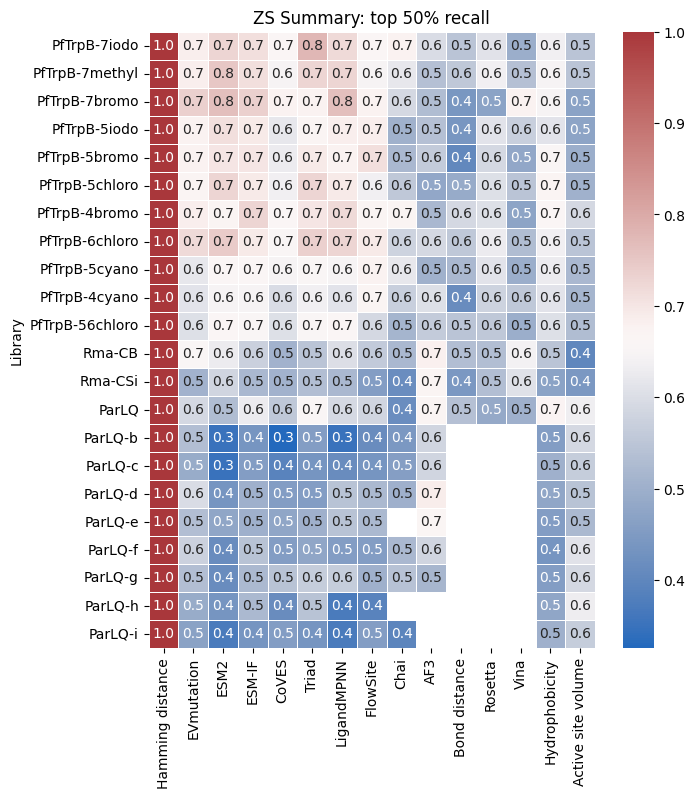

In [19]:

# Set the figure size
plt.figure(figsize=(7.2, 8))
# Create a heatmap
sns.heatmap(
    pd.concat([trpb_rho_df, cb_df, csi_df, parlq_rho_df])[
        [
            "Library",
            "Hamming distance",
            "EVmutation",
            "ESM2",
            "ESM-IF",
            "CoVES",
            "Triad",
            "LigandMPNN",
            "FlowSite",
            "Chai",
            "AF3",
            "Bond distance",
            "Rosetta",
            "Vina",
            "Hydrophobicity",
            "Active site volume",
        ]
    ]
    .set_index("Library")
    .reindex(custom_order),
    cmap="vlag",
    annot=True,
    fmt=".1f",
    linewidths=0.5,
)
# Show the plot
plt.title(r"ZS Summary: top 50% recall")

Text(0.5, 1.0, 'ZS Summary: top 50% recall for selectivity')

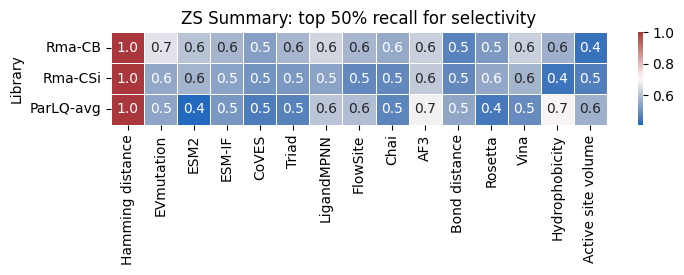

In [71]:
parlq_rho_df = df_top50_sele[df_top50_sele["lib"].isin(custom_order[-9:])].copy()# df_rho_fit[df_rho_fit["lib"] == "ParLQ"].copy()
parlq_rho_df = (
    parlq_rho_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_af3",
            # "0:C-C_1_avg_chai-struct_seperate",
            "0:C-C_1_avg_af3-struct_seperate",
            "ligandmpnn_score",
            "flowsite_score",
            "complexscore",
            "vina_apo-score-substrate_cofactor-docked",
            "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_separate",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_CA_avg_score_seperate_chai": "Chai",
            "chain_iptm_CA_avg_score_seperate_af3": "AF3",
            # "0:C-C_1_avg_chai-struct_seperate": "Bond distance (Chai)",
            "0:C-C_1_avg_af3-struct_seperate": "Bond distance",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "complexscore": "Rosetta",
            "vina_apo-score-substrate_cofactor-docked": "Vina",
            "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_separate": "Hydrophobicity",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)

parlqmean = parlq_rho_df.set_index("Library").mean().to_frame().T
parlqmean["Library"] = "ParLQ-avg"
parlqmean = parlqmean[["Library"] + parlqmean.columns.tolist()[:-1]].reset_index(drop=True)

cb_df = df_top50_sele[df_top50_sele["lib"] == "Rma-CB"].copy()
cb_df = (
    cb_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_af3",
            # "0:C-B_avg_chai-struct_joint",
            "0:C-B_avg_af3-struct_seperate",
            "ligandmpnn_score",
            "flowsite_score",
            "complexscore",
            "vina_apo-score-substrate_cofactor-docked",
            "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_separate",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_CA_avg_score_seperate_chai": "Chai",
            "chain_iptm_CA_avg_score_seperate_af3": "AF3",
            # "0:C-B_avg_chai-struct_joint": "Bond distance (Chai)",
            "0:C-B_avg_af3-struct_seperate": "Bond distance",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "complexscore": "Rosetta",
            "vina_apo-score-substrate_cofactor-docked": "Vina",
            "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_separate": "Hydrophobicity",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)

csi_df = df_top50_sele[df_top50_sele["lib"] == "Rma-CSi"].copy()
csi_df = (
    csi_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_CA_avg_score_seperate_chai",
            "chain_iptm_CA_avg_score_seperate_af3",
            # "0:C-Si_avg_chai-struct_joint",
            "0:C-Si_avg_af3-struct_seperate",
            "ligandmpnn_score",
            "flowsite_score",
            "complexscore",
            "vina_apo-score-substrate_cofactor-docked",
            "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_separate",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_CA_avg_score_seperate_chai": "Chai",
            "chain_iptm_CA_avg_score_seperate_af3": "AF3",
            # "0:C-Si_avg_chai-struct_joint": "Bond distance (Chai)",
            "0:C-Si_avg_af3-struct_seperate": "Bond distance",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "complexscore": "Rosetta",
            "vina_apo-score-substrate_cofactor-docked": "Vina",
            "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_separate": "Hydrophobicity",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)

# Set the figure size
plt.figure(figsize=(8, 1.2))
# Create a heatmap
sns.heatmap(
    pd.concat([cb_df, csi_df, parlqmean])[
        [
            "Library",
            "Hamming distance",
            "EVmutation",
            "ESM2",
            "ESM-IF",
            "CoVES",
            "Triad",
            "LigandMPNN",
            "FlowSite",
            "Chai",
            "AF3",
            "Bond distance",
            "Rosetta",
            "Vina",
            "Hydrophobicity",
            "Active site volume",
        ]
    ]
    .set_index("Library")
    .reindex(["Rma-CB", "Rma-CSi", "ParLQ-avg"]),
    cmap="vlag",
    annot=True,
    fmt=".1f",
    linewidths=0.5,
)
# Show the plot
plt.title(r"ZS Summary: top 50% recall for selectivity")

Text(0.5, 1.0, 'ZS Summary: top 50% recall for selectivity')

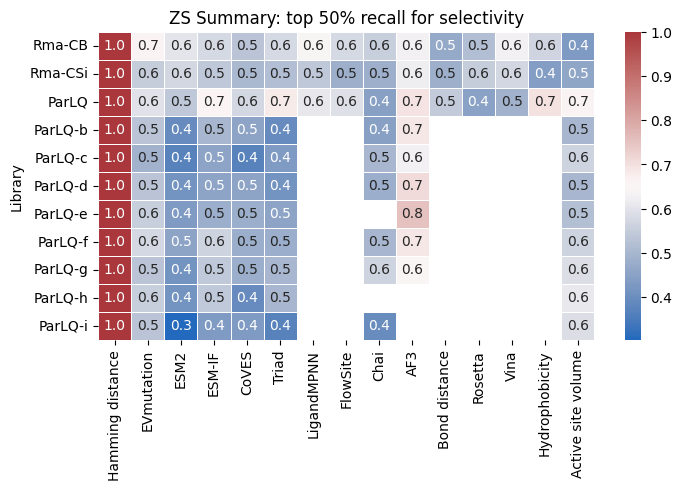

In [72]:

# Set the figure size
plt.figure(figsize=(8, 4))
# Create a heatmap
sns.heatmap(
    pd.concat([cb_df, csi_df, parlq_rho_df])[
        [
            "Library",
            "Hamming distance",
            "EVmutation",
            "ESM2",
            "ESM-IF",
            "CoVES",
            "Triad",
            "LigandMPNN",
            "FlowSite",
            "Chai",
            "AF3",
            "Bond distance",
            "Rosetta",
            "Vina",
            "Hydrophobicity",
            "Active site volume",
        ]
    ]
    .set_index("Library")
    .reindex(custom_order[-11:]),
    cmap="vlag",
    annot=True,
    fmt=".1f",
    linewidths=0.5,
)
# Show the plot
plt.title(r"ZS Summary: top 50% recall for selectivity")

In [73]:
df_rho_fit[df_rho_fit["lib"].isin(["PfTrpB_scope","Rma-CB_scope", "Rma-CSi_scope"])]

lib  selectivity     n_mut        hd  ev_score  esm_score  \
11  Rma-CSi_scope          NaN  0.124751 -0.124751 -0.124857  -0.124877   
15   Rma-CB_scope     0.531697  0.145924 -0.145924 -0.181266  -0.154170   
18   PfTrpB_scope          NaN -0.581300  0.581300  0.752160   0.752891   

    flowsite_score  flowsite_std  ligandmpnn_score   var_vol  ...  \
11             NaN           NaN               NaN -0.124991  ...   
15             NaN           NaN               NaN  0.150380  ...   
18             NaN           NaN               NaN  0.707870  ...   

    0:C-Si_agg_af3-struct_joint  0:C-Si_avg_af3-struct_joint  \
11                          NaN                          NaN   
15                          NaN                          NaN   
18                          NaN                          NaN   

    0:C-Si_std_af3-struct_joint  0:C-Si_agg_af3-struct_seperate  \
11                          NaN                             NaN   
15                          NaN                             NaN   
18                          NaN                             NaN   

    0:C-Si_avg_af3-struct_seperate  0:C-Si_std_af3-struct_seperate  \
11                             NaN                             NaN   
15                             NaN                             NaN   
18                             NaN                             NaN   

    0:C-Si_avg_chai-struct_joint  0:C-Si_std_chai-struct_joint  \
11                           NaN                           NaN   
15                           NaN                           NaN   
18                           NaN                           NaN   

    0:C-Si_avg_chai-struct_seperate  0:C-Si_std_chai-struct_seperate  
11                              NaN                              NaN  
15                              NaN                              NaN  
18                              NaN                              NaN  

[3 rows x 2720 columns]

Text(0.5, 1.0, 'ZS Summary: substrate scope spearman correlation')

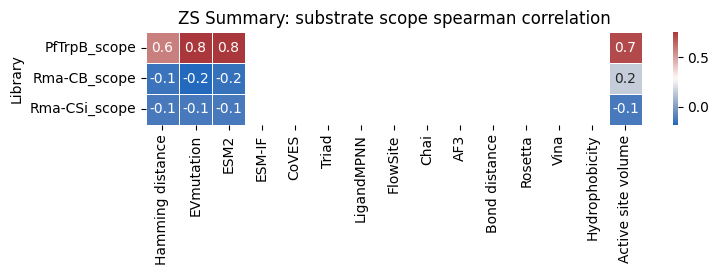

In [75]:
scope_rho_df = df_rho_fit[df_rho_fit["lib"].isin(["PfTrpB_scope","Rma-CB_scope", "Rma-CSi_scope"])]
scope_rho_df = (
    scope_rho_df[
        [
            "lib",
            "hd",
            "ev_score",
            "esm_score",
            "esmif_score_apo-score",
            "coves_score_apo_clean-output-100_processed",
            "Triad_score_score-frompdb-cleanup",
            "chain_iptm_AB_avg_score_joint_chai",
            "chain_iptm_AB_avg_score_joint_af3",
            "1:GLU-NH_1_avg_chai-struct_joint",
            # "1:GLU-NH_1_avg_af3-struct_joint",
            "ligandmpnn_score",
            "flowsite_score",
            "complexscore",
            "vina_apo-score-substrate_cofactor-docked",
            "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_joint",
            "var_vol",
        ]
    ]
    .rename(
        columns={
            "lib": "Library",
            "hd": "Hamming distance",
            "ev_score": "EVmutation",
            "esm_score": "ESM2",
            "esmif_score_apo-score": "ESM-IF",
            "coves_score_apo_clean-output-100_processed": "CoVES",
            "Triad_score_score-frompdb-cleanup": "Triad",
            "chain_iptm_AB_avg_score_joint_chai": "Chai",
            "chain_iptm_AB_avg_score_joint_af3": "AF3",
            "1:GLU-NH_1_avg_chai-struct_joint": "Bond distance",
            # "1:GLU-NH_1_avg_af3-struct_joint": "Bond distance (AF3)",
            "ligandmpnn_score": "LigandMPNN",
            "flowsite_score": "FlowSite",
            "complexscore": "Rosetta",
            "vina_apo-score-substrate_cofactor-docked": "Vina",
            "pocket-subcofcentroid-hw_avg - substrate-logp_af3-struct_joint": "Hydrophobicity",
            "var_vol": "Active site volume",
        }
    )
    .copy()
    .reset_index(drop=True)
)

# Set the figure size
plt.figure(figsize=(8, 1.2))
# Create a heatmap
sns.heatmap(
    scope_rho_df[
        [
            "Library",
            "Hamming distance",
            "EVmutation",
            "ESM2",
            "ESM-IF",
            "CoVES",
            "Triad",
            "LigandMPNN",
            "FlowSite",
            "Chai",
            "AF3",
            "Bond distance",
            "Rosetta",
            "Vina",
            "Hydrophobicity",
            "Active site volume",
        ]
    ]
    .set_index("Library")
    .reindex(["PfTrpB_scope", "Rma-CB_scope", "Rma-CSi_scope"]),
    cmap="vlag",
    annot=True,
    fmt=".1f",
    linewidths=0.5,
)
# Show the plot
plt.title("ZS Summary: substrate scope spearman correlation")